# Mortgage rates and Debt Status

In [193]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import gmaps
import requests
import time
import api_keys
from ipywidgets.embed import embed_minimal_html
from pprint import pprint
from pathlib import Path

In [194]:
# Assing raw data files
mort_inter_rates = "Resources/mortgage_interest_rates.xls"
affordablehousinginventory = "Resources/AHI_Affordable_Housing_Inventory.csv"
austinhousingandprice = "Resources/Austin Housing Income and Price Data.csv"
homeownership = "Resources/homeowner_rates_05_18.xlsx"
homepriceindex = 'Resources/HPI_master.csv'
vacancyrates = 'Resources/VacancyRates.xlsx'
house_hold_debt = "Resources/house_hold_report.xlsx"

# Read files and store into dataframes
mort_rates = pd.read_excel(mort_inter_rates)
AHI_to_load = pd.read_csv(affordablehousinginventory)
AustinHousingIncomeAndPriceData = pd.read_csv(austinhousingandprice)
ho_rates_df = pd.read_excel(homeownership, sheet_name="Sheet1")
HPI = pd.read_csv(homepriceindex)
VR = pd.read_excel(vacancyrates)

with pd.ExcelFile(house_hold_debt) as xls:
    df3 = pd.read_excel(xls, 'Page 3 Data', skiprows = [0,1], nrows = 7) #total debt balance and composition (trillions $)
    df4 = pd.read_excel(xls, 'Page 4 Data', skiprows = [0,1,2], nrows = 4) #number of accounts by loan type (millions)
    df6 = pd.read_excel(xls, 'Page 6 Data', skiprows = [0,1,2]) #mortgage origination volumn by riskscore (billions $)
    df12 = pd.read_excel(xls, 'Page 12 Data', skiprows = [0,1,2], nrows = 7) #% of balance 90+ days delinquent by loan type (%)
    df13 = pd.read_excel(xls, 'Page 13 Data', skiprows = [0,1], nrows = 7) #new delinquent balances by loan type (%)
    df17 = pd.read_excel(xls, 'Page 17 Data', skiprows = [0,1], nrows = 2) #number of consumers with new foreclosures and bankruptcies (Thousands)
    df24 = pd.read_excel(xls, 'Page 24 Data', skiprows = [0,1], nrows = 12) #% of mortgage debt 90+ days late by state (%)
    


In [195]:
# Establish gmaps configuration
gkey=api_keys.gkey
gmaps.configure(api_key=gkey)

In [196]:
# Preview mortgage rate dataframe
mort_rates.head()

Week  U.S. 30 yr FRM 30 yr fees & points  U.S. 15 yr FRM  \
0 1971-04-02            7.33                                 NaN   
1 1971-04-09            7.31                                 NaN   
2 1971-04-16            7.31                                 NaN   
3 1971-04-23            7.31                                 NaN   
4 1971-04-30            7.29                                 NaN   

   15 yr fees & points  U.S. 5/1 ARM  5/1 ARM fees & points  \
0                  NaN           NaN                    NaN   
1                  NaN           NaN                    NaN   
2                  NaN           NaN                    NaN   
3                  NaN           NaN                    NaN   
4                  NaN           NaN                    NaN   

   U.S. 5/1 ARM margin  30 yr FRM/ 5/1 ARM spread  
0                  NaN                        NaN  
1                  NaN                        NaN  
2                  NaN                        NaN  
3                  NaN                        NaN  
4                  NaN                        NaN

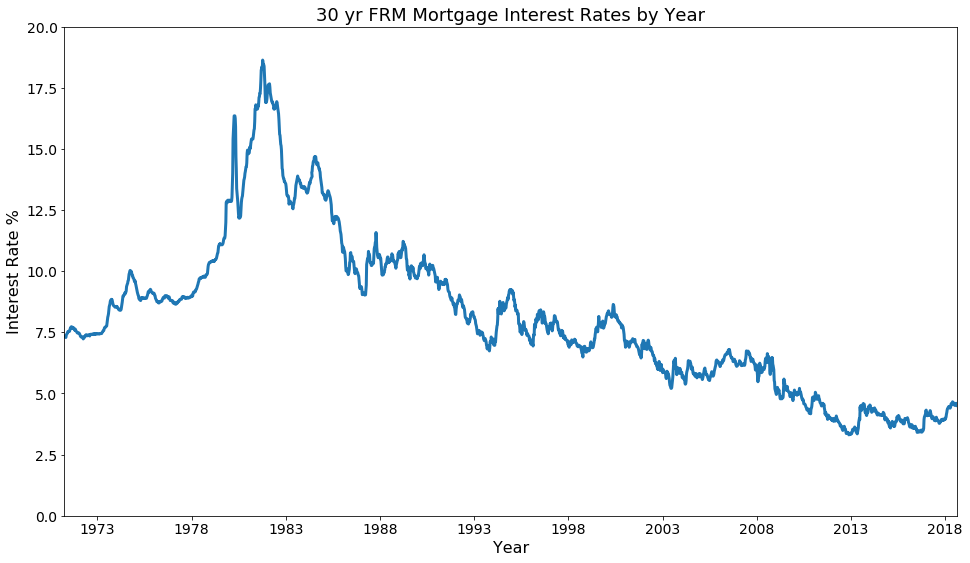

In [197]:
# Create fig and ax
figfrm = plt.figure(figsize = (16,9))
axfrm = plt.axes()

# Plot mortgage rate history
axfrm.plot(mort_rates['Week'], mort_rates['U.S. 30 yr FRM'],  ls = '-', lw = 3)

# Set plot features and fontsize
axfrm.set(ylim = (0, 20), xlim = ('4/2/1971', '8/23/2018'))
axfrm.set_title('30 yr FRM Mortgage Interest Rates by Year', fontsize = 18)
axfrm.set_ylabel('Interest Rate %', fontsize = 16)
axfrm.set_xlabel('Year', fontsize = 16)
axfrm.tick_params(labelsize = 14)

# Save figure to output folder
plt.savefig('Output/mort_int_rate.png')

In [198]:
# Assign periods for column headers
quarters = ['Period',
          'Q103', 'Q203', 'Q303', 'Q403', 
          'Q104', 'Q204', 'Q304', 'Q404',
          'Q105', 'Q205', 'Q305', 'Q405',
          'Q106', 'Q206', 'Q306', 'Q406',
          'Q107', 'Q207', 'Q307', 'Q407',
          'Q108', 'Q208', 'Q308', 'Q408',
          'Q109', 'Q209', 'Q309', 'Q409',
          'Q110', 'Q210', 'Q310', 'Q410',
          'Q111', 'Q211', 'Q311', 'Q411',
          'Q112', 'Q212', 'Q312', 'Q412',
          'Q113', 'Q213', 'Q313', 'Q413',
          'Q114', 'Q214', 'Q314', 'Q414',
          'Q115', 'Q215', 'Q315', 'Q415',
          'Q116', 'Q216', 'Q316', 'Q416',
          'Q117', 'Q217', 'Q317', 'Q417',
          'Q118', 'Q218']

quarters2 = ['Q105', 'Q205', 'Q305', 'Q405',
          'Q106', 'Q206', 'Q306', 'Q406',
          'Q107', 'Q207', 'Q307', 'Q407',
          'Q108', 'Q208', 'Q308', 'Q408',
          'Q109', 'Q209', 'Q309', 'Q409',
          'Q110', 'Q210', 'Q310', 'Q410',
          'Q111', 'Q211', 'Q311', 'Q411',
          'Q112', 'Q212', 'Q312', 'Q412',
          'Q113', 'Q213', 'Q313', 'Q413',
          'Q114', 'Q214', 'Q314', 'Q414',
          'Q115', 'Q215', 'Q315', 'Q415',
          'Q116', 'Q216', 'Q316', 'Q416',
          'Q117', 'Q217', 'Q317', 'Q417',
          'Q118', 'Q218', 'Q318', 'Q418']

In [199]:
# Drop blank columns
df_debt = df3.drop(df3.columns[[1,2]], axis = 1)

# Create column headers
df_debt.columns = quarters

# Assign index
df_debt = df_debt.set_index('Period')

# Transpose dataframe for plotting ease
df_debt = df_debt.transpose()

# Preview dataframe
df_debt.head()

Period  Mortgage  HE Revolving  Auto Loan  Credit Card  Student Loan   Other  \
Q103       4.942         0.242      0.641        0.688        0.2407  0.4776   
Q203       5.080         0.260      0.622        0.693        0.2429  0.4860   
Q303       5.183         0.269      0.684        0.693        0.2488  0.4773   
Q403       5.660         0.302      0.704        0.698        0.2529  0.4486   
Q104       5.840         0.328      0.720        0.695        0.2598  0.4465   

Period   Total  
Q103    7.2313  
Q203    7.3839  
Q303    7.5551  
Q403    8.0655  
Q104    8.2893

In [200]:
# Drop unnecessary columns
df_credit = df6.drop(df6.iloc[:,6:11], axis = 1)

# Rename quarter column to header
df_credit = df_credit.rename(columns = {'Unnamed: 0':'Period#'})

# Alter data in "Period" column to have consistent format
df_credit['Period'] = quarters[1:]

# Assign index
df_credit = df_credit.set_index('Period')

# Trim dataframe
df_credit = df_credit[['<620', '620-659', '660-719', '720-759', '760+']]

# Preview dataframe
df_credit.head()

<620  620-659  660-719  720-759    760+
Period                                          
Q103    72.19    68.12   188.33   336.10  304.24
Q203    71.41    70.53   203.73   352.85  316.03
Q303    78.15    81.23   215.70   363.92  324.71
Q403    90.06    86.37   212.36   349.56  289.70
Q104    79.29    63.47   150.00   213.45  150.59

In [201]:
df_foreclose = df17

# Create column headers
df_foreclose.columns = quarters

# Set index
df_foreclose = df_foreclose.set_index('Period')

# Transpose dataframe for plotting ease
df_foreclose = df_foreclose.transpose()

# Preview dataframe
df_foreclose.head()

Period  foreclosure  bankruptcy
Q103         203.32      612.26
Q203         169.90      628.66
Q303         178.16      542.44
Q403         193.24      516.02
Q104         186.06      534.90

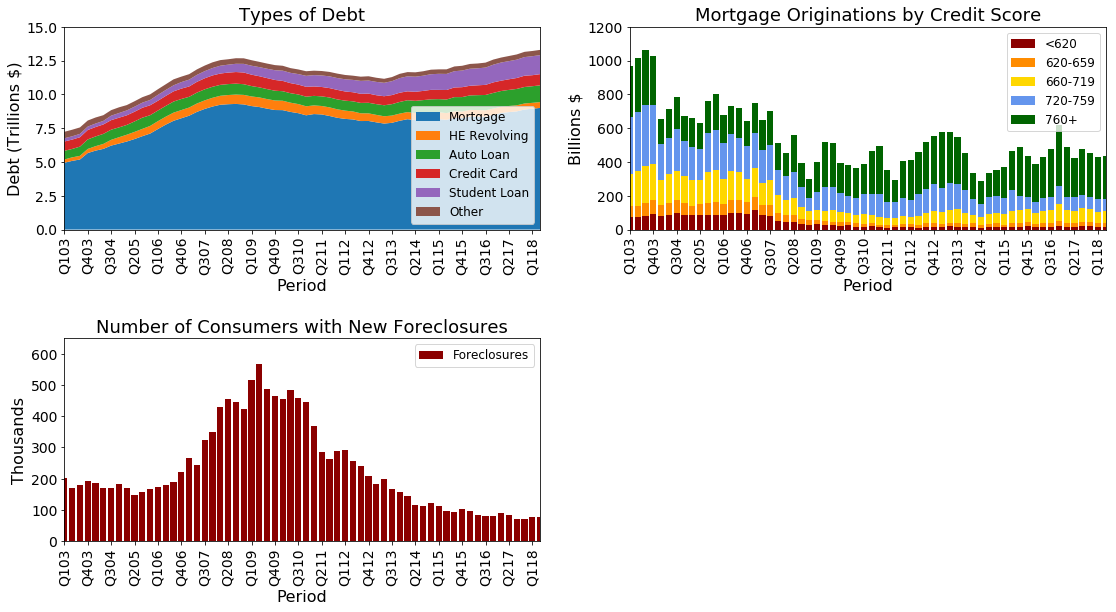

In [202]:
# Create fig with ratios for powerpoint
fig1 = plt.figure(figsize = (16,9))

# Create 1st of 2 x 2 subplots - Types of Debt
axdebt = plt.subplot(2,2,1)

# Assign labels for stackplot
labels = list(df_debt)
axdebt.stackplot(df_debt.index, df_debt['Mortgage'],
                 df_debt['HE Revolving'],
                 df_debt['Auto Loan'],
                 df_debt['Credit Card'],
                 df_debt['Student Loan'],
                 df_debt['Other'], labels = labels)

# Set plot features and fontsize
axdebt.set(ylim = (0, 15), xlim = ('Q103', 'Q218'))
axdebt.set_title('Types of Debt', fontsize = 18)
axdebt.set_ylabel('Debt (Trillions $)', fontsize = 16)
axdebt.set_xlabel('Period', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
axdebt.set_xticks(axdebt.get_xticks()[::3])
axdebt.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
axdebt.legend(loc = 'lower right', fontsize = 12)
axdebt.tick_params(labelsize = 14)


# Create 2nd of 2 x 2 subplots - Mortgage originations
axcredit = plt.subplot(2,2,2)

# Create Numpy arrays from dataframe for stacked bar plot
b1 = np.array(df_credit['<620'])
b2 = np.array(df_credit['620-659'])
b3 = np.array(df_credit['660-719'])
b4 = np.array(df_credit['720-759'])
b5 = np.array(df_credit['760+'])

# Plot stacked bars with each layer a cumulative of the previous layers
axcredit.bar(df_credit.index, b1, color = 'darkred')
axcredit.bar(df_credit.index, b2, bottom = b1, color = 'darkorange')
axcredit.bar(df_credit.index, b3, bottom = b1 + b2, color = 'gold')
axcredit.bar(df_credit.index, b4, bottom = b1 + b2 + b3, color = 'cornflowerblue')
axcredit.bar(df_credit.index, b5, bottom = b1 + b2 + b3 + b4, color = 'darkgreen')

# Set plot features and font size
axcredit.set(ylim = (0, 1200), xlim = ('Q103', 'Q218'))
axcredit.set_title('Mortgage Originations by Credit Score', fontsize = 18)
axcredit.set_ylabel('Billions $', fontsize = 16)
axcredit.set_xlabel('Period', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
axcredit.set_xticks(axcredit.get_xticks()[::3])
axcredit.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
axcredit.legend(('<620', '620-659', '660-719', '720-759', '760+'), loc = 'upper right', fontsize = 12)
axcredit.tick_params(labelsize = 14)


# Create 3rd of 2 x 2 subplots - Foreclosures
axforeclose = plt.subplot(2,2,3)

axforeclose.bar(df_foreclose.index, df_foreclose['foreclosure'], color = 'darkred')

# Set plot features and fontsize
axforeclose.set(ylim = (0, 650), xlim = ('Q103', 'Q218'))
axforeclose.set_title('Number of Consumers with New Foreclosures', fontsize = 18)
axforeclose.set_ylabel('Thousands', fontsize = 16)
axforeclose.set_xlabel('Period', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
axforeclose.set_xticks(axforeclose.get_xticks()[::3])
axforeclose.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
axforeclose.legend(['Foreclosures'], loc = 'upper right', fontsize = 12)
axforeclose.tick_params(labelsize = 14)

# Use pad to ensure labels and axis don't overlap
plt.tight_layout(pad = 2.5)

# Save figure to output file
plt.savefig('Output/debt.png')

In [203]:
df_90 = df12

# Create column headers
df_90.columns = quarters

# Set index
df_90 = df_90.set_index('Period')

# Transpose dataframe for plotting ease
df_90 = df_90.transpose()

# Preview dataframe
df_90.head()

Period  MORTGAGE  HELOC  AUTO    CC  STUDENT LOAN  OTHER       ALL
Q103        1.21   0.35  2.33  8.84      6.129123   7.23  2.566843
Q203        1.14   0.28  2.26  8.90      6.137217   7.13  2.492008
Q303        1.10   0.22  2.16  8.67      6.269695   6.88  2.392867
Q403        1.06   0.31  2.16  9.24      6.231594   7.47  2.352811
Q104        1.01   0.21  2.32  9.27      6.336297   7.68  2.311190

In [204]:
df_new = df13

# Create column headers
df_new.columns = quarters

# Set index
df_new = df_new.set_index('Period')

# Transpose dataframe for plotting ease
df_new = df_new.transpose()

# Preview dataframe
df_new.head()

Period      AUTO         CC  MORTGAGE     HELOC  STUDENT LOAN     OTHER  \
Q103    8.570162  12.321605  5.383374  2.942960           NaN  8.881383   
Q203    8.497427  12.271632  5.543065  2.677340           NaN  9.132189   
Q303    8.033501  11.739065  5.272001  2.525812           NaN  9.051247   
Q403    7.792019  11.560762  5.270055  2.025466           NaN  8.797358   
Q104    7.418313  10.893744  5.053103  1.933557      7.609623  8.944081   

Period     Total  
Q103    6.635781  
Q203    6.731470  
Q303    6.388400  
Q403    6.269924  
Q104    5.955924

In [205]:
df_state90 = df24

# Create column headers
df_state90.columns = quarters

# Set index
df_state90 = df_state90.set_index('Period')

# Transpose datafrome for ease of plotting
df_state90 = df_state90.transpose()

# Preview dataframe
df_state90.head()

Period        AZ        CA        FL        IL        MI        NJ        NV  \
Q103    1.634965  0.594722  1.306590  1.288175  1.506623  1.780045  1.299475   
Q203    1.357124  0.362121  1.505672  1.569822  1.383357  1.606162  2.118413   
Q303    1.615372  0.431873  0.985858  1.302861  1.288604  1.149925  1.857738   
Q403    1.405617  0.382749  0.995216  1.451363  1.232355  1.270432  2.311648   
Q104    0.946504  0.319836  0.944330  1.275507  1.131415  1.133393  1.828508   

Period        NY        OH        PA        TX       ALL  
Q103    1.649772  1.529880  1.415040  1.723783  1.208582  
Q203    1.520663  1.487077  1.134187  1.476392  1.140103  
Q303    1.457139  1.519217  1.067944  1.369409  1.096232  
Q403    1.472986  1.626337  0.871272  1.610607  1.057434  
Q104    1.316973  1.928839  1.053722  1.441940  1.010139

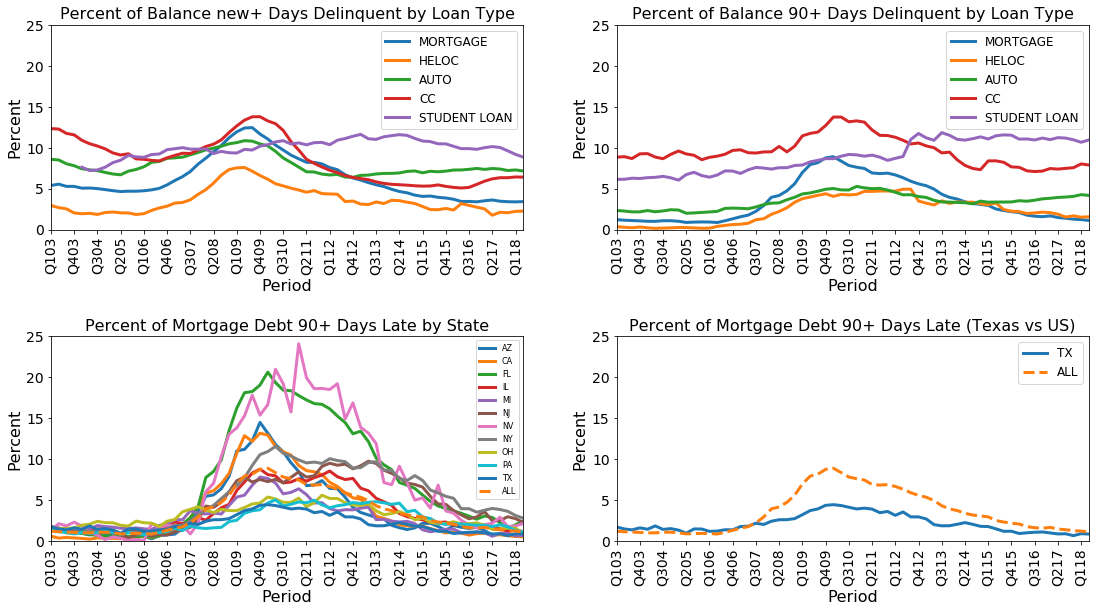

In [206]:
# Create fig with ratios for powerpoint
fig2 = plt.figure(figsize = (16,9))

# Create 1st subplot - New delinquency by debt type
axnew = plt.subplot(2,2,1)

axnew.plot(df_new.index, df_new['MORTGAGE'],  ls = '-', lw = 3)
axnew.plot(df_new.index, df_new['HELOC'],  ls = '-', lw = 3)
axnew.plot(df_new.index, df_new['AUTO'],  ls = '-', lw = 3)
axnew.plot(df_new.index, df_new['CC'],  ls = '-', lw = 3)
axnew.plot(df_new.index, df_new['STUDENT LOAN'],  ls = '-', lw = 3)

# Set plot features and fontsize
axnew.set(ylim = (0, 25), xlim = ('Q103', 'Q218'))
axnew.set_title('Percent of Balance new+ Days Delinquent by Loan Type', fontsize = 16)
axnew.set_ylabel('Percent', fontsize = 16)
axnew.set_xlabel('Period', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
axnew.set_xticks(axnew.get_xticks()[::3])
axnew.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
axnew.legend(loc = 'upper right', fontsize = 12)
axnew.tick_params(labelsize = 14)


# Create 2nd subplot - 90 day delinquency by debt type
ax90 = plt.subplot(2,2,2)

ax90.plot(df_90.index, df_90['MORTGAGE'],  ls = '-', lw = 3)
ax90.plot(df_90.index, df_90['HELOC'],  ls = '-', lw = 3)
ax90.plot(df_90.index, df_90['AUTO'],  ls = '-', lw = 3)
ax90.plot(df_90.index, df_90['CC'],  ls = '-', lw = 3)
ax90.plot(df_90.index, df_90['STUDENT LOAN'],  ls = '-', lw = 3)

# Set plot features and fontsize
ax90.set(ylim = (0, 25), xlim = ('Q103', 'Q218'))
ax90.set_title('Percent of Balance 90+ Days Delinquent by Loan Type', fontsize = 16)
ax90.set_ylabel('Percent', fontsize = 16)
ax90.set_xlabel('Period', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
ax90.set_xticks(ax90.get_xticks()[::3])
ax90.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
ax90.legend(loc = 'upper right', fontsize = 12)
ax90.tick_params(labelsize = 14)


# Create 3rd subplot - State delinquency
axstate90 = plt.subplot(2,2,3)

axstate90.plot(df_state90.index, df_state90['AZ'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['CA'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['FL'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['IL'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['MI'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['NJ'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['NV'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['NY'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['OH'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['PA'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['TX'],  ls = '-', lw = 3)
axstate90.plot(df_state90.index, df_state90['ALL'],  ls = '--', lw = 3)

# Set plot features and fontsize
axstate90.set(ylim = (0, 25), xlim = ('Q103', 'Q218'))
axstate90.set_title('Percent of Mortgage Debt 90+ Days Late by State', fontsize = 16)
axstate90.set_ylabel('Percent', fontsize = 16)
axstate90.set_xlabel('Period', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
axstate90.set_xticks(axstate90.get_xticks()[::3])
axstate90.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
axstate90.legend(loc = 'upper right', fontsize = 8)
axstate90.tick_params(labelsize = 14)


# Create 4th subplot - Texas only
axtexas = plt.subplot(2,2,4)

axtexas.plot(df_state90.index, df_state90['TX'],  ls = '-', lw = 3)
axtexas.plot(df_state90.index, df_state90['ALL'],  ls = '--', lw = 3)

# Set plot features and fontsize
axtexas.set(ylim = (0, 25), xlim = ('Q103', 'Q218'))
axtexas.set_title('Percent of Mortgage Debt 90+ Days Late (Texas vs US)', fontsize = 16)
axtexas.set_ylabel('Percent', fontsize = 16)
axtexas.set_xlabel('Period', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
axtexas.set_xticks(axstate90.get_xticks())
axtexas.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
axtexas.legend(loc = 'upper right', fontsize = 12)
axtexas.tick_params(labelsize = 14)

# Use pad to ensure labels and axis don't overlap
plt.tight_layout(pad = 2.5)

# Save figure to output folder
plt.savefig('Output/delinquent.png')

# HPI Analysis

In [207]:
# Preview the data
HPI.head()

hpi_type     hpi_flavor  frequency level place_name  place_id    yr  \
0  traditional  purchase-only  quarterly   MSA  Akron, OH     10420  1991   
1  traditional  purchase-only  quarterly   MSA  Akron, OH     10420  1991   
2  traditional  purchase-only  quarterly   MSA  Akron, OH     10420  1991   
3  traditional  purchase-only  quarterly   MSA  Akron, OH     10420  1991   
4  traditional  purchase-only  quarterly   MSA  Akron, OH     10420  1992   

   period  index_nsa  index_sa  
0       1     100.00    100.00  
1       2     102.47    101.19  
2       3     101.98    101.39  
3       4     103.05    103.09  
4       1     104.55    104.54

In [208]:
# Reframe the data by cities
HPI_1 = HPI.groupby(['place_name','yr'])['index_sa'].mean()
HPI_1 = HPI_1.reset_index()
HPI_1.head()

place_name    yr  index_sa
0  Akron, OH  1991  101.4175
1  Akron, OH  1992  106.6200
2  Akron, OH  1993  112.2225
3  Akron, OH  1994  117.8225
4  Akron, OH  1995  123.4000

In [209]:
# Find top 4 MSA by rate difference

# Trim data to zoom to 2005 - 2012
HPI_1_trim = HPI_1[(HPI_1['yr'] >= 2005) & (HPI_1['yr'] <= 2012)]

# Find max of each MSA
HPI_1_max = pd.DataFrame(HPI_1_trim.groupby(['place_name'])['index_sa'].max())

# Find min of eash MSA
HPI_1_min = pd.DataFrame(HPI_1_trim.groupby(['place_name'])['index_sa'].min())

# Merge into one dataframe and calculate the difference between max and min
HPI_1_diff = HPI_1_max.merge(HPI_1_min, on = 'place_name', suffixes = ('_max', '_min'))
HPI_1_diff['Rate_Diff'] = HPI_1_diff['index_sa_min'] - HPI_1_diff['index_sa_max']

# Take top 10 MSAs with largest difference
HPI_1_diff = HPI_1_diff.nsmallest(10, 'Rate_Diff').reset_index()

# Create a list of top 10
HPI_1_top10 = list(HPI_1_diff['place_name'])

In [210]:
# Index the data by city and year
HPI_2 = pd.pivot_table(HPI_1, values='index_sa', index='yr', columns='place_name')

# Preview dataframe
HPI_2.head()

place_name  Akron, OH  Albany-Schenectady-Troy, NY  Albuquerque, NM  \
yr                                                                    
1991         101.4175                      99.9900         101.1050   
1992         106.6200                     101.9825         107.2550   
1993         112.2225                     100.2325         116.4050   
1994         117.8225                      97.8950         130.5750   
1995         123.4000                      95.1250         137.4475   

place_name  Allentown-Bethlehem-Easton, PA-NJ  \
yr                                              
1991                                 100.1275   
1992                                 100.9200   
1993                                 100.0025   
1994                                  99.6975   
1995                                  97.9350   

place_name  Anaheim-Santa Ana-Irvine, CA (MSAD)  \
yr                                                
1991                                    99.8175   
1992                                    97.7725   
1993                                    91.4575   
1994                                    86.4825   
1995                                    84.2650   

place_name  Atlanta-Sandy Springs-Roswell, GA  Austin-Round Rock, TX  \
yr                                                                     
1991                                 100.1500               101.5550   
1992                                 101.8575               110.4725   
1993                                 104.2125               123.2350   
1994                                 108.1800               134.0575   
1995                                 112.6550               137.7350   

place_name  Bakersfield, CA  Baltimore-Columbia-Towson, MD  Baton Rouge, LA  \
yr                                                                            
1991               100.1125                        99.8875         101.4800   
1992               100.7575                       102.0650         106.1250   
1993                97.6550                       101.6550         113.9025   
1994                95.4175                       102.6425         120.9900   
1995                92.2125                       102.6700         125.7350   

place_name        ...         Tucson, AZ  Tulsa, OK  \
yr                ...                                 
1991              ...           100.8150   100.4700   
1992              ...           104.3925   101.9400   
1993              ...           111.5225   107.6250   
1994              ...           122.3350   112.2250   
1995              ...           128.4275   115.0525   

place_name  Virginia Beach-Norfolk-Newport News, VA-NC  \
yr                                                       
1991                                           99.1750   
1992                                          101.3250   
1993                                          103.2175   
1994                                          106.0250   
1995                                          107.7425   

place_name  Warren-Troy-Farmington Hills, MI (MSAD)  \
yr                                                    
1991                                       100.9225   
1992                                       104.6625   
1993                                       107.5425   
1994                                       113.2775   
1995                                       122.2300   

place_name  Washington-Arlington-Alexandria, DC-VA-MD-WV (MSAD)  \
yr                                                                
1991                                                  99.4750     
1992                                                  99.8150     
1993                                                  98.9925     
1994                                                  99.4200     
1995                                                  97.9550     

place_name  West Palm Beach-Boca Raton-Delray Beach, FL (MSAD)  Wichita, KS  \
yr           

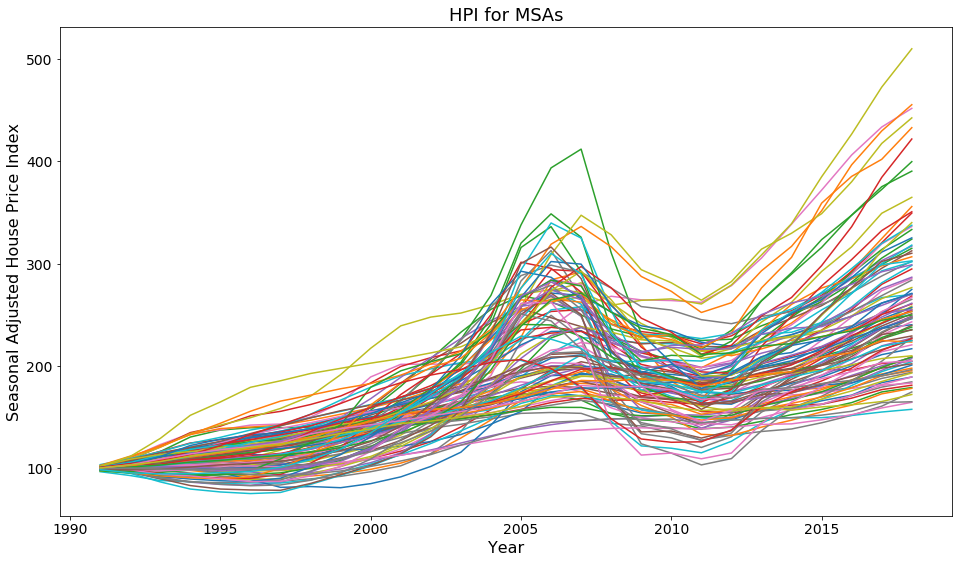

In [211]:
# HPI line chart from 1991 - 2018 for all cities
axhpi = HPI_2.plot(kind = 'line', legend = False, figsize = (16,9))

# Set plot features and fontsize
axhpi.set_title('HPI for MSAs', fontsize = 18)
axhpi.set_xlabel("Year", fontsize = 16)
axhpi.set_ylabel("Seasonal Adjusted House Price Index", fontsize = 16)
axhpi.tick_params(labelsize = 14)

# Save figure to output folder
plt.savefig('Output/hpi.png')

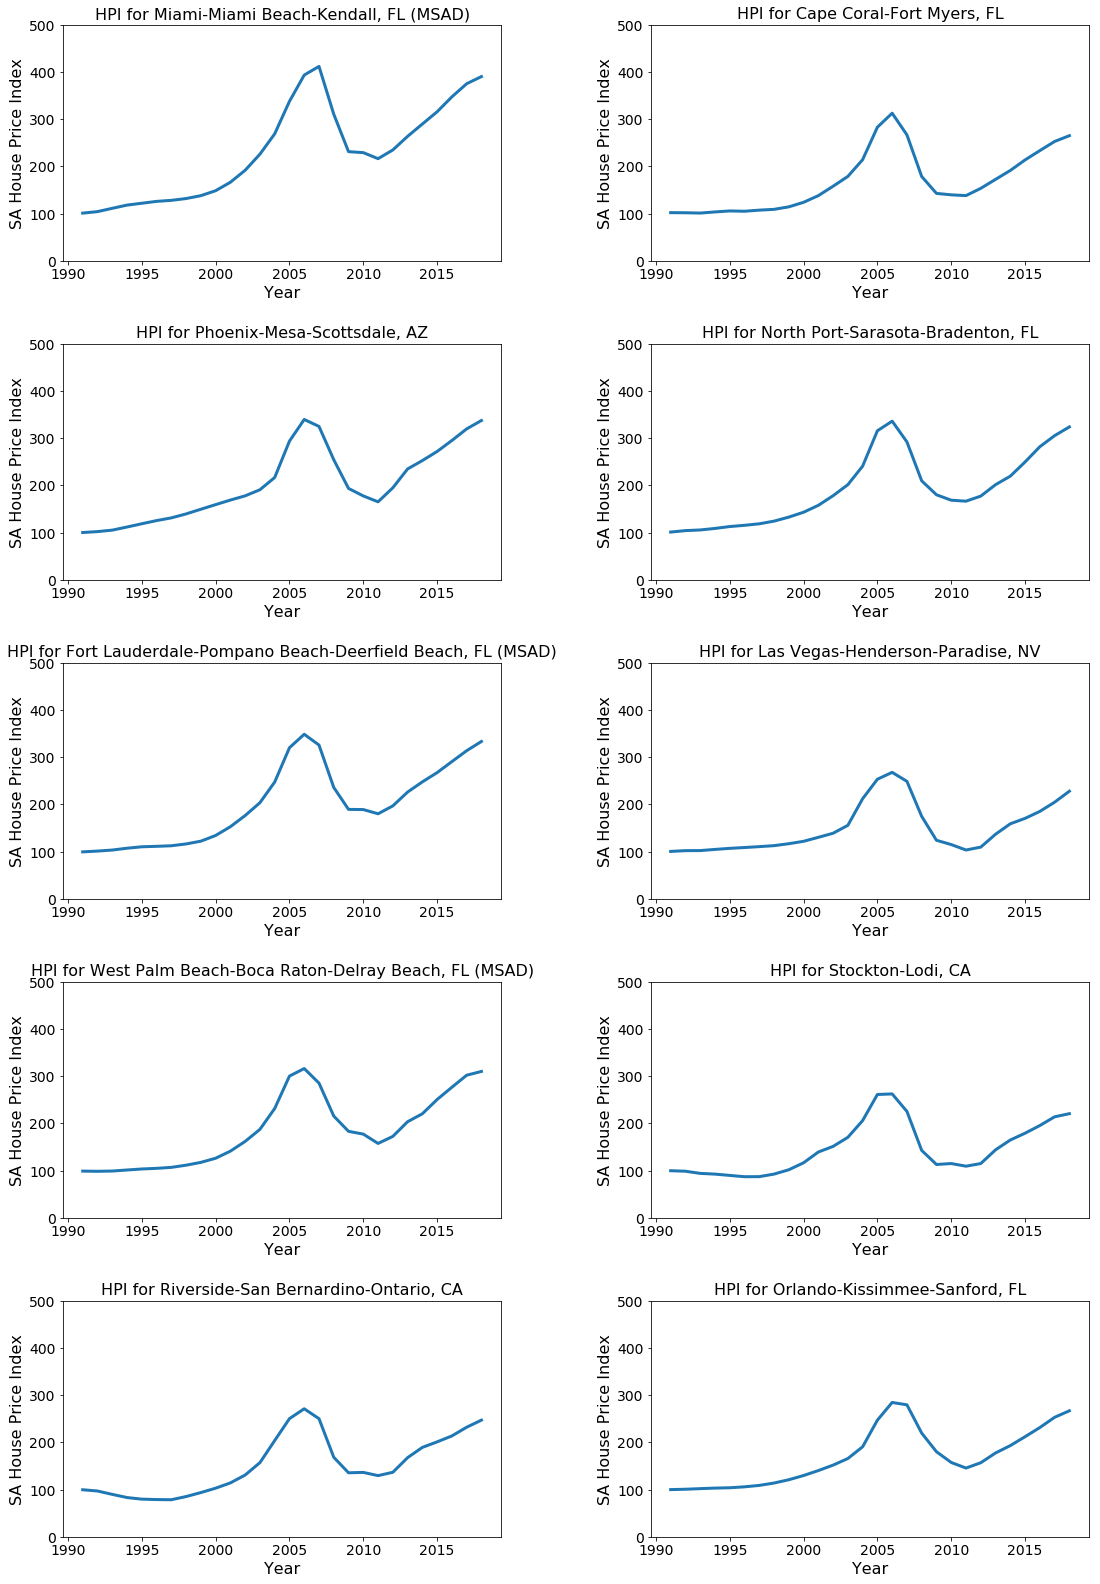

In [212]:
# HPI line chart for top 10 MSA from 1991 - 2018

# Create fig with ratios for powerpoint
fig4 = plt.figure(figsize = (16,22.5))

count = 0

# Loop to plot top 10 MSA
for city in HPI_2[HPI_1_top10]:
    
    # Create nth subplot
    axhpi2 = plt.subplot(5,2,1+count)
    
    axhpi2.plot(HPI_2.index, HPI_2[city], lw = 3)
    
    # Set plot features and fontsize
    axhpi2.set(ylim = (0, 500))
    axhpi2.set_title('HPI for ' + city, fontsize = 16)
    axhpi2.set_xlabel('Year', fontsize = 16)
    axhpi2.set_ylabel('SA House Price Index', fontsize = 16)
    axhpi2.tick_params(labelsize = 14)
    count += 1

# Use pad to ensure labels and axis don't overlap 
plt.tight_layout(pad = 2.5)

# Save figure to output folder
plt.savefig('Output/hpi_top10.png')

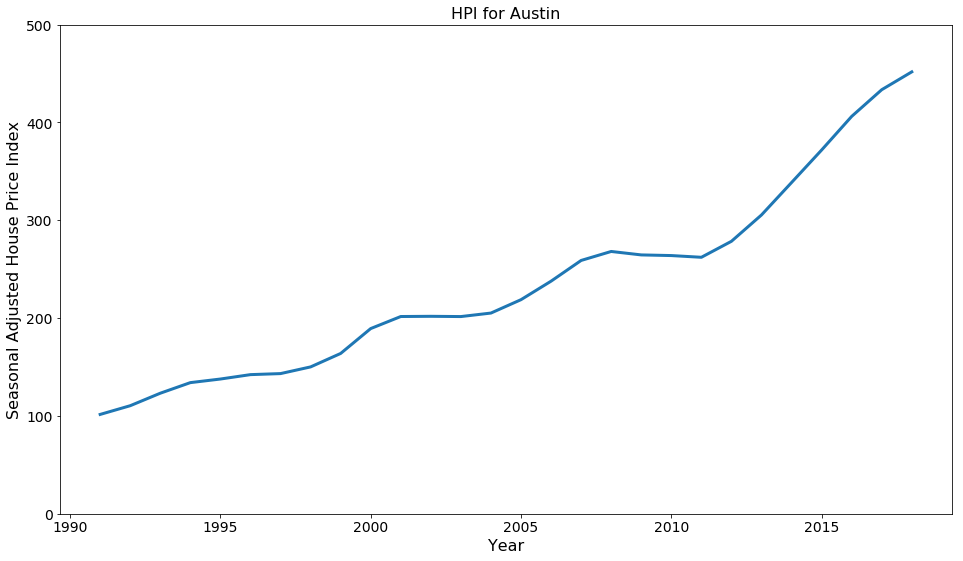

In [213]:
# Austin HPI
austin_hpi = 'Austin-Round Rock, TX'

# Create fig with ratios for powerpoint
fig7 = plt.figure(figsize = (16,9))
axahpi = plt.axes()

axahpi.plot(HPI_2.index, HPI_2[austin_hpi], lw = 3)

# Set plot features and fontsize
axahpi.set_title('HPI for Austin', fontsize = 16)
axahpi.set(ylim = (0, 500))
axahpi.set_xlabel('Year', fontsize = 16)
axahpi.set_ylabel('Seasonal Adjusted House Price Index', fontsize = 16)
axahpi.tick_params(labelsize = 14)

# Save figure to output folder
plt.savefig('Output/hpi_austin.png')

# Homeownership Rates

In [214]:
# Preview dataframe
ho_rates_df.head()

MSA  Q105  Q205  Q305  Q405  Q106  Q206  \
0                            Akron, OH   75.7  81.0  79.3  76.2  75.3  75.3   
1          Albany-Schenectady-Troy, NY   72.0  66.5  61.7  65.2  65.8  68.7   
2                       Albuquerque, NM  70.5  69.1  69.3  68.2  70.0  68.9   
3     Allentown-Bethlehem-Easton, PA-NJ  71.9  72.5  75.3  74.3  74.5  78.2   
4  Atlanta-Sandy Springs-Marietta, GA\1  65.0  63.7  66.1  70.7  68.9  67.4   

   Q306  Q406  Q107  ...   Q116  Q216  Q316  Q416  Q117  Q217  Q317  Q417  \
0  79.5  78.6  80.5  ...   71.2  76.6  77.7  73.2  70.0  68.0  68.2  64.2   
1  66.7  66.9  66.5  ...   65.6  60.8  58.2  60.9  69.3  67.2  60.6  60.0   
2  71.5  69.5  67.4  ...   70.3  66.2  66.4  64.7  66.6  68.1  66.0  67.4   
3  74.0  73.8  74.6  ...   69.4  69.1  68.9  68.4  70.8  74.7  74.8  72.1   
4  68.5  66.9  68.8  ...   62.9  62.1  59.3  61.6  64.4  61.1  61.8  62.2   

   Q118  Q218  
0  73.1  69.3  
1  58.2  63.1  
2  70.7  67.0  
3  71.7  74.8  
4  67.4  62.3  

[5 rows x 55 columns]

In [215]:
# Undo pivot table
ho_rates_df = pd.melt(ho_rates_df, id_vars="MSA", value_vars = quarters2, var_name = "Period", value_name = "Rate")

# Preview datafraem
ho_rates_df.head()

C:\ProgramData\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


MSA Period  Rate
0                            Akron, OH    Q105  75.7
1          Albany-Schenectady-Troy, NY    Q105  72.0
2                       Albuquerque, NM   Q105  70.5
3     Allentown-Bethlehem-Easton, PA-NJ   Q105  71.9
4  Atlanta-Sandy Springs-Marietta, GA\1   Q105  65.0

In [216]:
# Create quarter and year columns
ho_rates_df['Quarter'] = ho_rates_df.Period.str[1]
ho_rates_df['Year'] = pd.to_numeric("20" + ho_rates_df.Period.str[2:4]) # Format data type in the year column to integer

# Preview new dataframe
ho_rates_df.head()

MSA Period  Rate Quarter  Year
0                            Akron, OH    Q105  75.7       1  2005
1          Albany-Schenectady-Troy, NY    Q105  72.0       1  2005
2                       Albuquerque, NM   Q105  70.5       1  2005
3     Allentown-Bethlehem-Easton, PA-NJ   Q105  71.9       1  2005
4  Atlanta-Sandy Springs-Marietta, GA\1   Q105  65.0       1  2005

In [217]:
# New dataframe grouped by Year using mean
ho_rates_group = ho_rates_df.groupby(['MSA', 'Year'])['Rate'].mean()
ho_rates_group = ho_rates_group.reset_index()

# Preview dataframe
ho_rates_group.head()

MSA  Year    Rate
0  Akron, OH   2005  78.050
1  Akron, OH   2006  77.175
2  Akron, OH   2007  74.750
3  Akron, OH   2008  77.350
4  Akron, OH   2009  77.200

In [218]:
# Re-pivot data for index rate by year
ho_rates_pivot = pd.pivot_table(ho_rates_group, values='Rate', index='Year', columns='MSA')

# Preview dataframe
ho_rates_pivot.head()

MSA   Akron, OH   Albany-Schenectady-Troy, NY   Albuquerque, NM  \
Year                                                              
2005      78.050                        66.350           69.275   
2006      77.175                        67.025           69.975   
2007      74.750                        68.050           70.450   
2008      77.350                        69.500           68.200   
2009      77.200                        71.075           65.650   

MSA   Allentown-Bethlehem-Easton, PA-NJ  Atlanta-Sandy Springs-Marietta, GA\1  \
Year                                                                            
2005                             73.500                                66.375   
2006                             75.125                                67.925   
2007                             74.100                                66.350   
2008                             74.075                                67.500   
2009                             72.400                                67.725   

MSA   Austin-Round Rock, TX\2  Bakersfield, CA  Baltimore-Towson, MD\3  \
Year                                                                     
2005                   63.825           60.475                  70.650   
2006                   66.625           62.175                  72.950   
2007                   66.450           66.625                  71.175   
2008                   65.475           59.375                  69.350   
2009                   63.975           58.475                  67.750   

MSA   Baton Rouge, LA  Birmingham-Hoover, AL\4      ...        \
Year                                                ...         
2005           70.775                   75.125      ...         
2006           65.000                   76.125      ...         
2007           66.650                   75.000      ...         
2008           74.150                   73.300      ...         
2009           70.450                   75.125      ...         

MSA   Springfield, MA  St Louis, MO-IL  Syracuse, NY  \
Year                                                   
2005           64.525           74.350        59.725   
2006           62.325           72.825        66.025   
2007           58.775           72.050        63.350   
2008           63.725           72.175        62.350   
2009           68.925           72.500        61.275   

MSA   Tampa-St Petersburg-Clearwater, FL  Toledo, OH  Tucson, AZ   Tulsa, OK  \
Year                                                                           
2005                              71.700      72.425       66.125     71.700   
2006                              71.600      70.750       67.425     67.800   
2007                              72.925      68.225       67.100     66.625   
2008                              70.500      67.125       63.575     66.650   
2009                              68.300      61.225       65.475     67.725   

MSA   Virginia Beach-Norfolk-Newport News, VA\35  \
Year                                               
2005                                      68.050   
2006                                      68.350   
2007                                      66.050   
2008                                      63.875   
2009                                      63.525   

MSA   Washington-Arlington-Alexandria, DC-VA-MD-WV\36  Worcester, MA  
Year                                                                  
2005                                           68.450         65.150  
2006                                           68.900         70.975  
2007                                           69.200         67.825  
2008                                           68.100         68.550  
2009                                           67.175         64.475  

[5 rows x 75 columns]

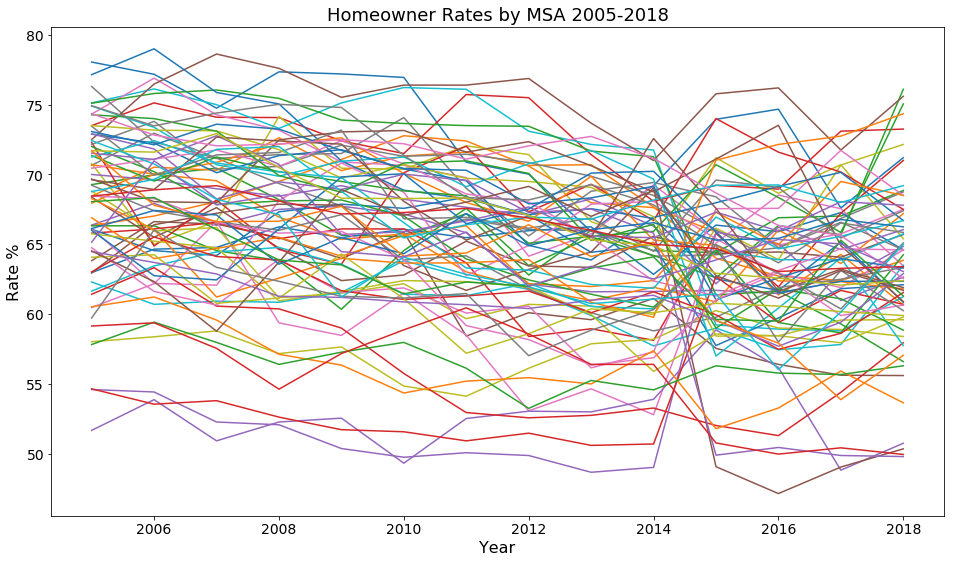

In [219]:
# Plot all MSA line charts

ho_line_plot = ho_rates_pivot.plot(kind = 'line', legend = False, figsize = (16,9))

# Set plot features and fontsize
ho_line_plot.set_title("Homeowner Rates by MSA 2005-2018", fontsize = 18)
ho_line_plot.set_xlabel("Year", fontsize = 16)
ho_line_plot.set_ylabel("Rate %", fontsize = 16)
ho_line_plot.tick_params(labelsize = 14)

# Save figure to output folder
plt.savefig('Output/homeowner.png')

In [220]:
# Assign top 4 HOVR MSAs
HOVR_top4 = ['Miami-Fort Lauderdale-Miami Beach, FL\\20',
           'Phoenix-Mesa-Scottsdale, AZ\\24',
           'Las Vegas-Paradise, NV\\18',
           'Riverside-San Bernardino-Ontario, CA\\29']

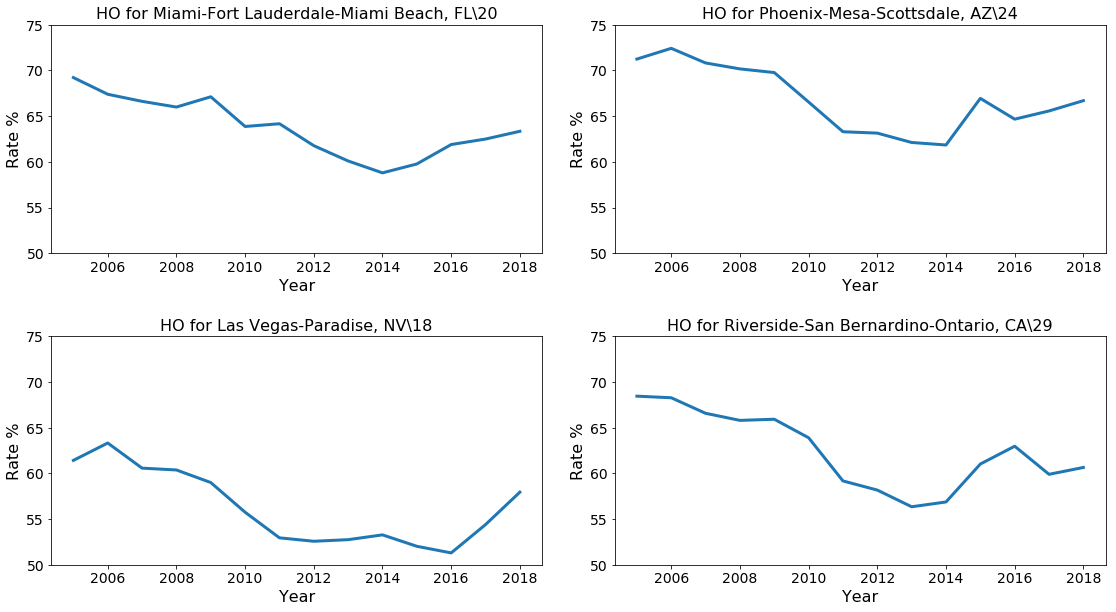

In [221]:
# Plot line charts for top 4 MSAs

# Create fig with ratios for powerpoint
fig5 = plt.figure(figsize = (16,9))

count2 = 0

for MSA in ho_rates_pivot[HOVR_top4]:
    
    # Create nth subplot
    axho = plt.subplot(2,2,1+count2)
    
    axho.plot(ho_rates_pivot.index, ho_rates_pivot[MSA], lw = 3)
    
    # Set plot features and fontsize
    axho.set_title('HO for ' + MSA, fontsize = 16)
    axho.set(ylim = (50, 75))
    axho.set_xlabel('Year', fontsize = 16)
    axho.set_ylabel('Rate %', fontsize = 16)
    axho.tick_params(labelsize = 14)
    count2 += 1

# Use pad to ensure labels and axis don't overlap 
plt.tight_layout(pad = 2.5)

# Save figure to output folder
plt.savefig('Output/homeowner_top4.png')

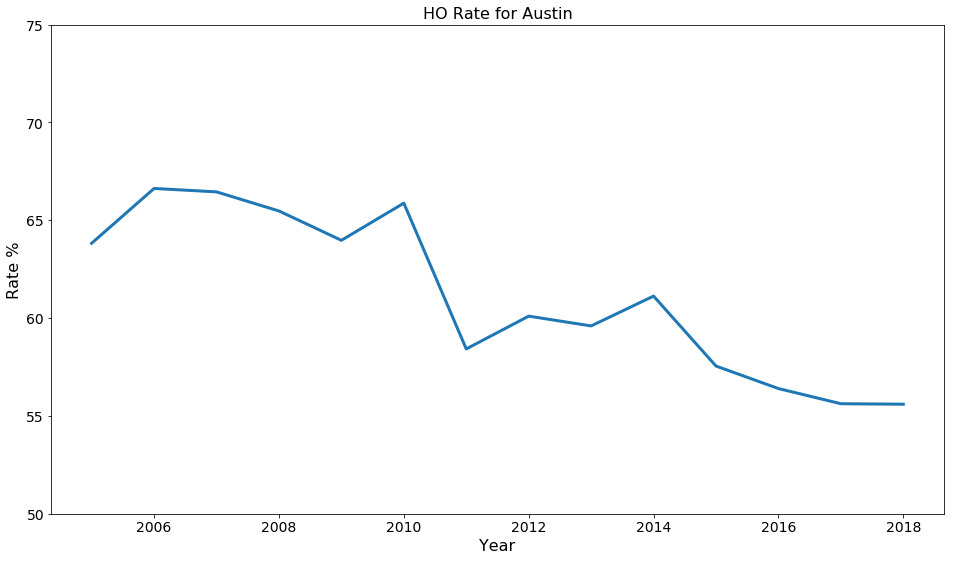

In [222]:
# HO Rate for Austin
austin_hovr = 'Austin-Round Rock, TX\\2'

# Create fig with ratios for powerpoint
fig8 = plt.figure(figsize = (16,9))
axaho = plt.axes()

axaho.plot(ho_rates_pivot.index, ho_rates_pivot[austin_hovr], lw = 3)

# Set plot features and fontsize
axaho.set_title('HO Rate for Austin', fontsize = 16)
axaho.set(ylim = (50, 75))
axaho.set_xlabel('Year', fontsize = 16)
axaho.set_ylabel('Rate %', fontsize = 16)
axaho.tick_params(labelsize = 14)

# Save figure to output folder
plt.savefig('Output/homeowner_austin.png')

# Vacancy Rates

In [223]:
# Preview dataframe
VR.head()

MSA  Q105  Q205  Q305  Q405  Q106  Q206  \
0                            Akron, OH    3.0   1.3   2.6   1.6   1.2   2.8   
1          Albany-Schenectady-Troy, NY    1.6   0.4   2.6   3.5   0.7   0.7   
2                       Albuquerque, NM   2.5   2.0   1.5   1.1   0.7   2.2   
3     Allentown-Bethlehem-Easton, PA-NJ   0.0   0.0   1.0   1.3   0.6   0.4   
4  Atlanta-Sandy Springs-Marietta, GA\1   2.9   3.7   3.9   3.1   3.4   3.1   

   Q306  Q406  Q107  ...   Q316  Q416  Q117  Q217  Q317  Q417  Q118  Q218  \
0   3.2   5.6   4.3  ...    1.2   0.5   1.0   0.0   0.0   1.1   0.5   0.0   
1   1.8   2.9   2.1  ...    0.4   2.2   2.2   1.6   1.8   2.9   1.8   0.4   
2   1.8   3.3   1.8  ...    2.4   1.5   1.5   2.2   2.6   2.1   1.9   1.7   
3   1.3   1.9   1.1  ...    2.0   1.8   2.5   1.1   1.6   1.6   0.0   0.0   
4   4.5   4.5   3.7  ...    1.8   1.5   0.6   0.9   1.2   1.3   1.2   0.9   

   Q318  Q418  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN  

[5 rows x 57 columns]

In [224]:
# Undo pivot table
VR = pd.melt(VR, id_vars='MSA', value_vars = quarters2, var_name = "Period", value_name = "Rate")

# Preview dataframe
VR.head()

MSA Period  Rate
0                            Akron, OH    Q105   3.0
1          Albany-Schenectady-Troy, NY    Q105   1.6
2                       Albuquerque, NM   Q105   2.5
3     Allentown-Bethlehem-Easton, PA-NJ   Q105   0.0
4  Atlanta-Sandy Springs-Marietta, GA\1   Q105   2.9

In [225]:
# Create quarter and year columns
VR['Quarter'] = VR.Period.str[1]
VR['Year'] = pd.to_numeric( "20" + VR.Period.str[2:4])  # Format data type in the year column to integer

# Preview dataframe
VR.head()

MSA Period  Rate Quarter  Year
0                            Akron, OH    Q105   3.0       1  2005
1          Albany-Schenectady-Troy, NY    Q105   1.6       1  2005
2                       Albuquerque, NM   Q105   2.5       1  2005
3     Allentown-Bethlehem-Easton, PA-NJ   Q105   0.0       1  2005
4  Atlanta-Sandy Springs-Marietta, GA\1   Q105   2.9       1  2005

In [226]:
# Group by MSA and year and take the mean of the 4 quarters for each year per MSA
VR_group = VR.groupby(['MSA', 'Year'])['Rate'].mean()
VR_group = VR_group.reset_index()

# Preview dataframe
VR_group.head()

MSA  Year   Rate
0  Akron, OH   2005  2.125
1  Akron, OH   2006  3.200
2  Akron, OH   2007  4.475
3  Akron, OH   2008  3.025
4  Akron, OH   2009  2.925

In [227]:
# Create a pivot table to index rate by year
vacancy = pd.pivot_table(VR_group, values='Rate', index='Year', columns='MSA')

# Preview dataframe
vacancy.head()

MSA   Akron, OH   Albany-Schenectady-Troy, NY   Albuquerque, NM  \
Year                                                              
2005       2.125                         2.025            1.775   
2006       3.200                         1.525            2.000   
2007       4.475                         2.125            2.550   
2008       3.025                         2.225            1.850   
2009       2.925                         2.375            1.950   

MSA   Allentown-Bethlehem-Easton, PA-NJ  Atlanta-Sandy Springs-Marietta, GA\1  \
Year                                                                            
2005                              0.575                                 3.400   
2006                              1.050                                 3.875   
2007                              1.225                                 4.725   
2008                              1.300                                 4.800   
2009                              1.950                                 4.075   

MSA   Austin-Round Rock, TX\2  Bakersfield, CA  Baltimore-Towson, MD\3  \
Year                                                                     
2005                    2.425             1.45                   1.500   
2006                    1.550             2.30                   2.425   
2007                    1.500             1.25                   2.750   
2008                    2.300             2.90                   2.275   
2009                    1.625             3.45                   1.950   

MSA   Baton Rouge, LA  Birmingham-Hoover, AL\4      ...        \
Year                                                ...         
2005            2.200                    1.600      ...         
2006            0.925                    2.850      ...         
2007            1.625                    2.500      ...         
2008            0.925                    3.350      ...         
2009            2.925                    2.125      ...         

MSA   Springfield, MA  St. Louis, MO-IL  Syracuse, NY  \
Year                                                    
2005            0.425             2.075         1.225   
2006            0.625             2.175         1.825   
2007            1.400             1.750         3.150   
2008            1.825             3.075         2.350   
2009            1.300             1.800         0.800   

MSA   Tampa-St. Petersburg-Clearwater, FL  Toledo, OH  Tucson, AZ  Tulsa, OK  \
Year                                                                           
2005                                1.825       2.350       1.475      3.375   
2006                                3.525       2.300       1.925      1.800   
2007                                5.100       2.375       2.250      3.325   
2008                                3.000       2.125       1.800      2.900   
2009                                4.125       3.075       2.675      2.425   

MSA   Virginia Beach-Norfolk-Newport News, VA\35  \
Year                                               
2005                                       0.650   
2006                                       1.250   
2007                                       3.350   
2008                                       3.225   
2009                                       2.300   

MSA   Washington-Arlington-Alexandria, DC-VA-MD-WV\36  Worcester, MA  
Year                                                                  
2005                                            1.275          1.400  
2006                                            2.150          1.575  
2007                                            2.450          0.500  
2008                                            2.700          1.275  
2009                                            2.275          1.775  

[5 rows x 75 columns]

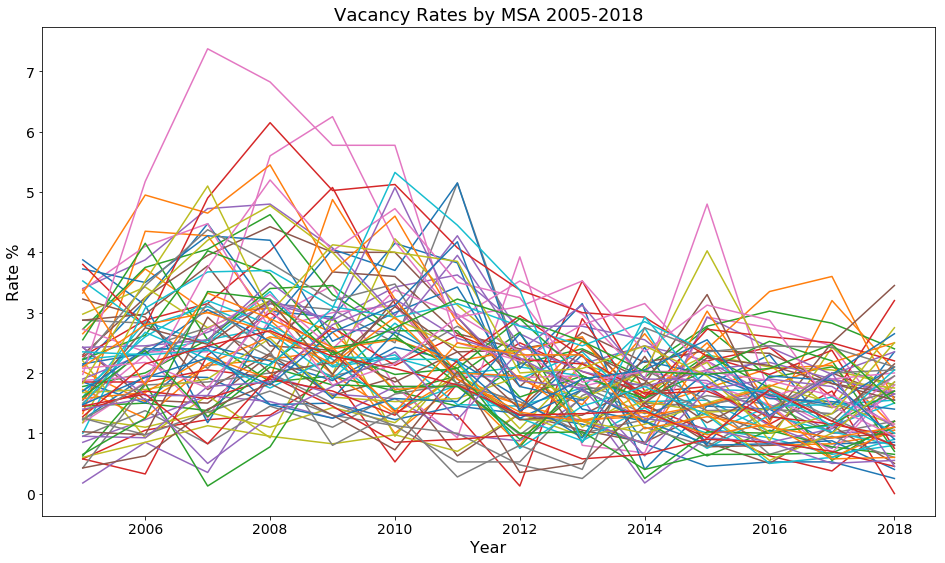

In [228]:
# Plot line chart based on the pivot table
vr_line_plot = vacancy.plot(kind = 'line', legend = False, figsize = (16,9))

# Set plot features and fontsize
vr_line_plot.set_title("Vacancy Rates by MSA 2005-2018", fontsize = 18)
vr_line_plot.set_xlabel("Year", fontsize = 16)
vr_line_plot.set_ylabel("Rate %", fontsize = 16)
vr_line_plot.tick_params(labelsize = 14)

# Save figure to output folder
plt.savefig('Output/vacancy_rates.png')

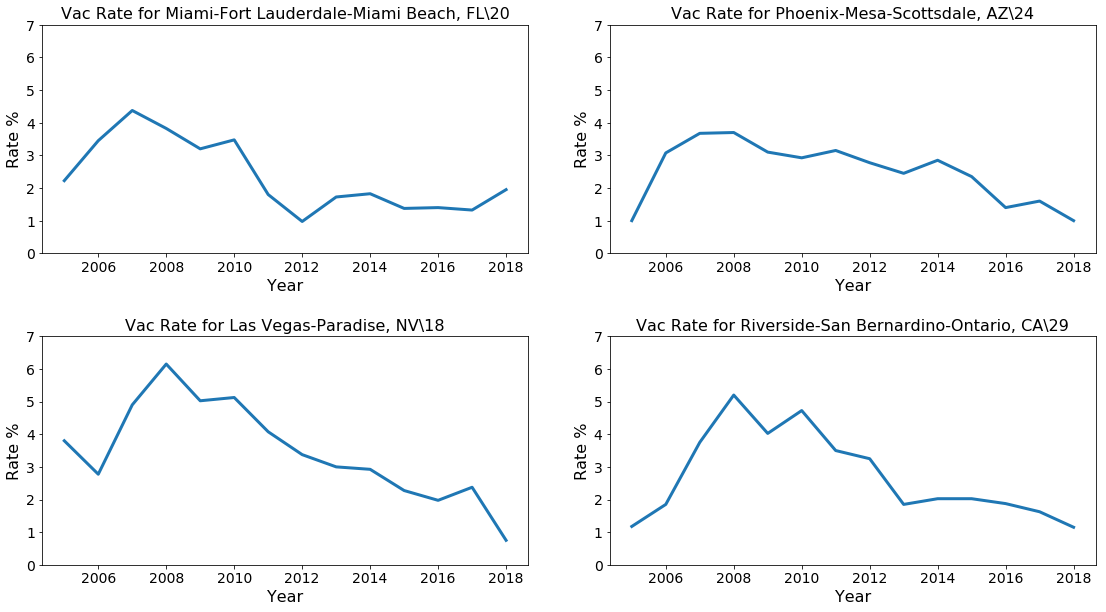

In [229]:
# Plot line charts for top 4 MSAs

# Create fig with ratios for powerpoint
fig6 = plt.figure(figsize = (16,9))

count3 = 0

for MSA in vacancy[HOVR_top4]:
    
    # Create nth subplot
    axvr = plt.subplot(2,2,1+count3)
    
    axvr.plot(vacancy.index, vacancy[MSA], lw = 3)
    
    # Set plot features and fontsize
    axvr.set_title('Vac Rate for ' + MSA, fontsize = 16)
    axvr.set(ylim = (0.0, 7.0))
    axvr.set_xlabel('Year', fontsize = 16)
    axvr.set_ylabel('Rate %', fontsize = 16)
    axvr.tick_params(labelsize = 14)
    count3 += 1

# Use pad to ensure labels and axis don't overlap    
plt.tight_layout(pad = 2.5)
    
# Save figure to output folder
plt.savefig('Output/vacancy_top4.png')

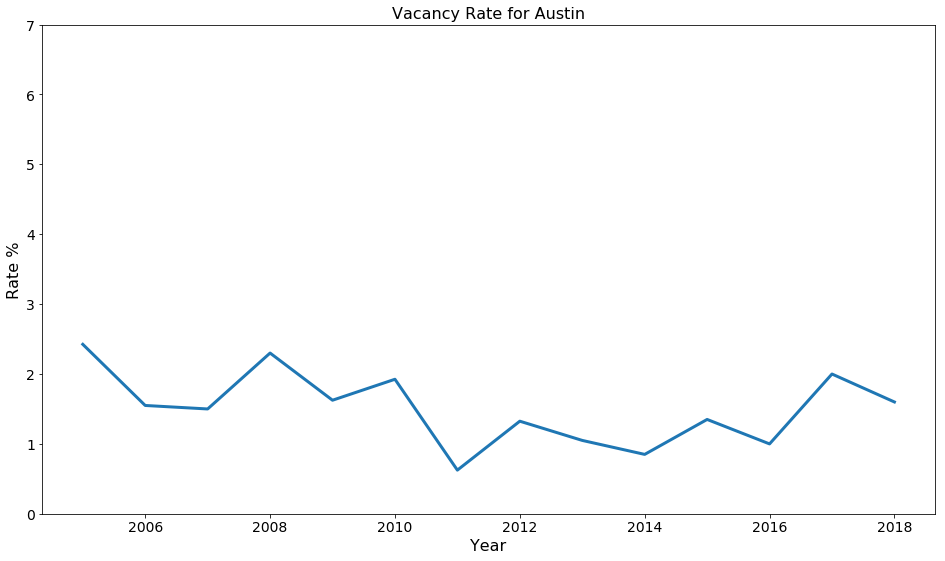

In [230]:
# Vacancy Rate for Austin

# Create fig with ratios for powerpoint
fig9 = plt.figure(figsize = (16,9))
axavr = plt.axes()

axavr.plot(vacancy.index, vacancy[austin_hovr], lw = 3)

# Set plot features and fontsize
axavr.set_title('Vacancy Rate for Austin', fontsize = 16)
axavr.set(ylim = (0, 7.0))
axavr.set_xlabel('Year', fontsize = 16)
axavr.set_ylabel('Rate %', fontsize = 16)
axavr.tick_params(labelsize = 14)

# Save figure to output folder
plt.savefig('Output/vacancy_austin.png')

# Affordable Housing Inventory (AHI)

In [231]:
# Preview dataframe
AHI_to_load.head()

AHI #  Project ID                           Project Name  \
0      2        3225                              M Station   
1      3        3226                Garden Terrace Phase II   
2      4        3227  LifeWorks Transitional Living Project   
3      5        3228                            Cornerstone   
4      6        3229                            The Willows   

                                Owner                     Developer  \
0        Foundation Communities, Inc.  Foundation Communities, Inc.   
1  Garden Terrace Housing Corporation  Foundation Communities, Inc.   
2                           Lifeworks                     Lifeworks   
3                  Mary Lee Community           Mary Lee Foundation   
4                  Mary Lee Community           Mary Lee Foundation   

                                  Address  Zip Code   Council District  \
0  2906 E Martin Luther King Jr Boulevard      78722               1.0   
1             1015 W William Cannon Drive      78745               2.0   
2                       3710 S 2nd Street      78704               3.0   
3                 1322 Lamar Square Drive      78704               5.0   
4                 1330 Lamar Square Drive      78704               5.0   

  Kirwan Opportunity Index  Total Units  \
0                Very High          150   
1                      Low           15   
2                 Very Low           12   
3                 Very Low           30   
4                 Moderate           64   

                   ...                       CIP  UNO TF  Total City Funding   \
0                  ...                    $0.00    $0.00       $2,000,000.00    
1                  ...                    $0.00    $0.00         $500,000.00    
2                  ...                    $0.00    $0.00         $300,000.00    
3                  ...                    $0.00    $0.00       $1,009,502.00    
4                  ...                    $0.00    $0.00       $2,250,000.00    

  LIHTC  Property Management Company  Phone Number  \
0     9%      Foundation Communities  512-474-6767   
1    NaN      Foundation Communities  512-416-8300   
2    NaN                   Lifeworks  512-735-2100   
3    NaN         Mary Lee Foundation  512-443-5777   
4    NaN         Mary Lee Foundation  512-443-5777   

                                            Website   Longitude   Latitude  \
0  http://foundcom.org/housing/our-austin-communi... -97.708414  30.282007   
1  http://foundcom.org/housing/our-austin-communi... -97.793427  30.198641   
2            http://www.lifeworksaustin.org/housing/ -97.771020  30.229837   
3  http://www.maryleefoundation.org/programs-and-... -97.764224  30.255306   
4  http://www.maryleefoundation.org/programs-and-... -97.765039  30.254456   

                                Location  
0  (30.2820072186666, -97.7084137218687)  
1  (30.1986408937312, -97.7934265318501)  
2  (30.2298368209301, -97.7710197443868)  
3  (30.2553062066707, -97.7642238885743)  
4   (30.2544562030313, -97.765039314016)  

[5 rows x 64 columns]

In [232]:
# Extracting the columns we need for the analysis
AHI_new = AHI_to_load[['Zip Code ','Unit Type', 'Tenure','Total City Funding ','Longitude','Latitude',]].copy()
AHI_new = AHI_new.dropna()

# Preview dataframe
AHI_new.head()

Zip Code     Unit Type  Tenure Total City Funding   Longitude   Latitude
0      78722  Multifamily  Rental      $2,000,000.00  -97.708414  30.282007
1      78745  Multifamily  Rental        $500,000.00  -97.793427  30.198641
2      78704  Multifamily  Rental        $300,000.00  -97.771020  30.229837
3      78704  Multifamily  Rental      $1,009,502.00  -97.764224  30.255306
4      78704  Multifamily  Rental      $2,250,000.00  -97.765039  30.254456

In [233]:
# Flitering the data based on 'Ownership' and 'Single Family'
AHI=AHI_new.loc[(AHI_new['Tenure'] == "Ownership")]
          
# Reset index
AHI = AHI.reset_index()

In [234]:
# Assign locations
locations = AHI[["Latitude", "Longitude"]].astype(float)

In [235]:
# Data scruming
ints=locations["Latitude"]
for idx, val in enumerate(ints):
    if(val>31):
        print(idx, val)
        locations=locations.drop(idx)

893 3029439926.0


In [236]:
# Create a AHI Heatmap layer
ahi_layer = gmaps.symbol_layer(
    locations, fill_color='red', stroke_color='red', scale=2)
fig = gmaps.figure()
fig.add_layer(ahi_layer)

# Create html in output folder
embed_minimal_html('Output/AHI_Map.html', views=[fig])

# Austin Housing Income and Price Data

In [237]:
# Preview dataframe
AustinHousingIncomeAndPriceData.head()

Zip Code Population below poverty level Median household income  \
0     78726                             9%                  66,096   
1     78724                            38%                  35,711   
2     78617                            18%                  43,957   
3     78701                            20%                  68,152   
4     78702                            33%                  34,734   

  Non-White, Non-Hispanic or Latino Hispanic or Latino, of any race  \
0                               16%                             20%   
1                               29%                             63%   
2                               12%                             67%   
3                               16%                             14%   
4                               18%                             56%   

  Population with disability Unemployment Large households (5+ members)  \
0                         3%           4%                            2%   
1                         8%           8%                           28%   
2                        10%          15%                           23%   
3                        10%           9%                            0%   
4                        14%          11%                           10%   

  Homes affordable to people earning less than $50,000  \
0                                                 0%     
1                                                85%     
2                                                NaN     
3                                                 7%     
4                                                21%     

  Rentals affordable to people earning less than $25,000    ...      \
0                                                 1%        ...       
1                                                16%        ...       
2                                                11%        ...       
3                                                 7%        ...       
4                                                41%        ...       

  Rental units affordable to average tech worker  \
0                                            99%   
1                                           100%   
2                                            99%   
3                                            90%   
4                                            99%   

  Owner units affordable to average tech worker  \
0                                           17%   
1                                           96%   
2                                           NaN   
3                                           30%   
4                                           67%   

  Change in percentage of population below poverty, 2000-2012  \
0                                               375%            
1                                               208%            
2                                               101%            
3                                                12%            
4                                                 3%            

  Change in median rent, 2000-2012 Change in median home value, 2000-2012  \
0                              20%                                    55%   
1                              37%                                    46%   
2                              74%                                    21%   
3                             115%                                    59%   
4                              73%                                   207%   

  Percentage of homes within 1/4-mi of transit stop  \
0                                                2%   
1                                               21%   
2                                               16%   
3                                               97%   
4                                               96%   

  Average monthly transportation cost  \
0                                 786   
1                                 786   


In [238]:
# Extracting the columns we need for the analysis
AustinHousingIncomeAndPriceData_new = AustinHousingIncomeAndPriceData[['Zip Code','Median home value','Longitude','Latitude',]].copy()

# Drop NA data
AustinHousingIncomeAndPriceData_new = AustinHousingIncomeAndPriceData_new.dropna()

# Preview dataframe
AustinHousingIncomeAndPriceData_new.head()

Zip Code Median home value  Longitude   Latitude
0     78726           349,900 -97.839500  30.419100
1     78724           105,700 -97.738824  30.256483
2     78617           100,600 -97.622300  30.294400
3     78701           338,300 -97.738824  30.256483
4     78702           175,400 -97.716349  30.267095

In [239]:
# Assign locations and median home value
locations = AustinHousingIncomeAndPriceData_new[["Latitude", "Longitude"]].astype(float)
median_hv = AustinHousingIncomeAndPriceData_new["Median home value"]

In [240]:
sum=0
arr=[]

# Find cumulative median home values of all zipcodes 
for idx, val in enumerate(median_hv):
    val = int(val.replace(',','')) # Remove comma and convert to an integer
    sum = sum + val

# Find average home value of each zipcode
for idx, val in enumerate(median_hv):
    val = int(val.replace(',','')) # Remove comma and convert to an integer
    avg = val/sum
    arr.append(avg*1000)

# Create dataframe from average values
arr = pd.DataFrame(arr).astype(float)

In [241]:
# Create a AHIPD Heatmap layer
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=arr,point_radius=20))

# Create html in output folder
embed_minimal_html('Output/AHIPD_Map.html', views=[fig])

# INDEX - Code that didn't make the final cut.

In [242]:
df_account = df4

# Create column headers
df_account.columns = quarters

# Assign index
df_account = df_account.set_index('Period')

# Transpose dataframe for plotting ease
df_account = df_account.transpose()

# Preview dataframe
df_account.head()

Period  Auto Loan  Credit Card  Mortgage  HE Revolving
Q103        73.51       469.81     79.54         13.41
Q203        70.76       468.94     79.73         14.22
Q303        75.94       457.64     79.34         15.55
Q403        77.64       452.71     83.42         16.10
Q104        79.22       449.62     83.95         16.73

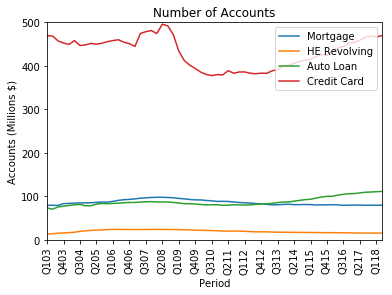

In [243]:
# Create fig and ax
figaccount = plt.figure()
axaccount = plt.axes()

axaccount.plot(df_account.index, df_account['Mortgage'],  ls = '-')
axaccount.plot(df_account.index, df_account['HE Revolving'],  ls = '-')
axaccount.plot(df_account.index, df_account['Auto Loan'],  ls = '-')
axaccount.plot(df_account.index, df_account['Credit Card'],  ls = '-')

# Set plot features and fontsize
axaccount.set(title = 'Number of Accounts', 
       ylabel = 'Accounts (Millions $)', 
       xlabel = 'Period', 
       ylim = (0, 500),
       xlim = ('Q103', 'Q218'))

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
axaccount.set_xticks(axaccount.get_xticks()[::3])
axaccount.set_xticklabels(labels = quarters[1::3], rotation = 90)

# Assign legend location and label size
axaccount.legend(loc = 'upper right')

In [244]:
# Housing Price Index percentage change analysis
HPI_3 = HPI_2.pct_change()

for i in range(1992,2019):
    print(i)
    percentage_change = HPI_3.loc[i]
    print(percentage_change)

1992
place_name
Akron, OH                                                    0.051298
Albany-Schenectady-Troy, NY                                  0.019927
Albuquerque, NM                                              0.060828
Allentown-Bethlehem-Easton, PA-NJ                            0.007915
Anaheim-Santa Ana-Irvine, CA (MSAD)                         -0.020487
Atlanta-Sandy Springs-Roswell, GA                            0.017049
Austin-Round Rock, TX                                        0.087810
Bakersfield, CA                                              0.006443
Baltimore-Columbia-Towson, MD                                0.021800
Baton Rouge, LA                                              0.045773
Birmingham-Hoover, AL                                        0.048330
Boise City, ID                                               0.081230
Boston, MA (MSAD)                                           -0.011190
Bridgeport-Stamford-Norwalk, CT                              0.000653
Buff

In [245]:
# Sort the percentage change from max to min
minVal = HPI_3.min()
minVal.sort_values()

place_name
Stockton-Lodi, CA                                          -0.366474
Cape Coral-Fort Myers, FL                                  -0.330660
Riverside-San Bernardino-Ontario, CA                       -0.326911
Las Vegas-Henderson-Paradise, NV                           -0.298169
North Port-Sarasota-Bradenton, FL                          -0.282084
Fort Lauderdale-Pompano Beach-Deerfield Beach, FL (MSAD)   -0.275922
Bakersfield, CA                                            -0.270073
Oakland-Hayward-Berkeley, CA (MSAD)                        -0.268070
Miami-Miami Beach-Kendall, FL (MSAD)                       -0.255458
Fresno, CA                                                 -0.248153
West Palm Beach-Boca Raton-Delray Beach, FL (MSAD)         -0.244664
Phoenix-Mesa-Scottsdale, AZ                                -0.239052
Sacramento--Roseville--Arden-Arcade, CA                    -0.236868
Los Angeles-Long Beach-Glendale, CA (MSAD)                 -0.233014
Orlando-Kissimmee-Sanfo

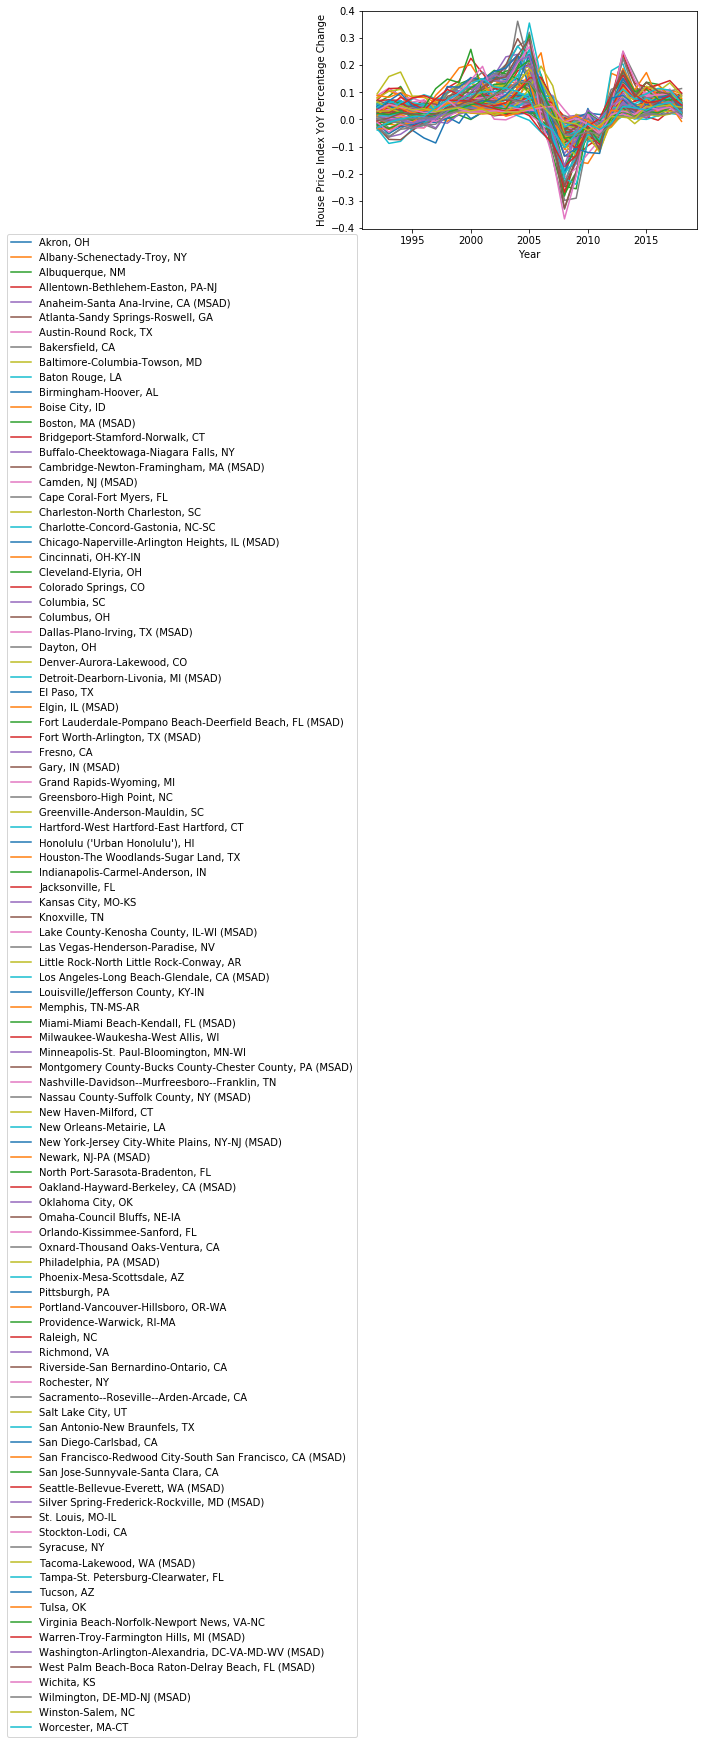

In [246]:
# HPI percentage change YoY for all cities from 1991 to 2018
c = HPI_3.plot(kind = 'line')
plt.legend(bbox_to_anchor=(0, 0))
c.set_xlabel('Year')
c.set_ylabel('House Price Index YoY Percentage Change')
plt.show()

Akron, OH


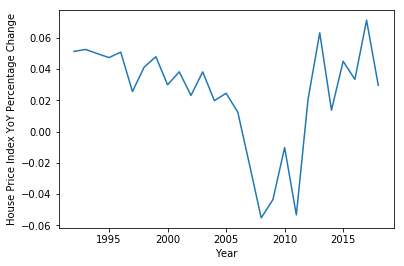

--------------
Albany-Schenectady-Troy, NY


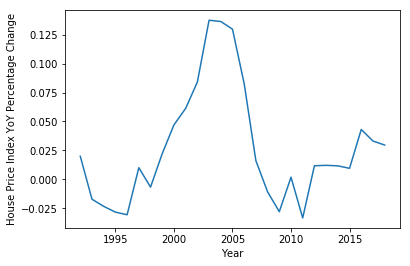

--------------
Albuquerque, NM


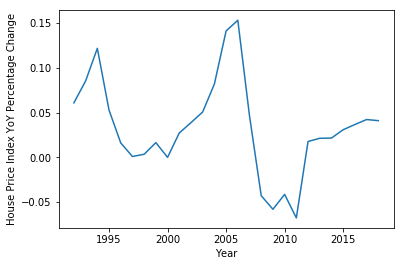

--------------
Allentown-Bethlehem-Easton, PA-NJ


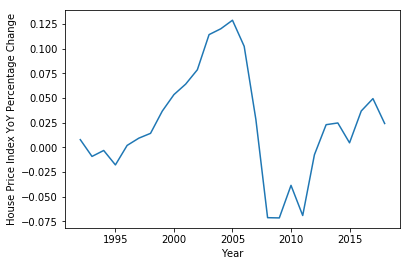

--------------
Anaheim-Santa Ana-Irvine, CA (MSAD)


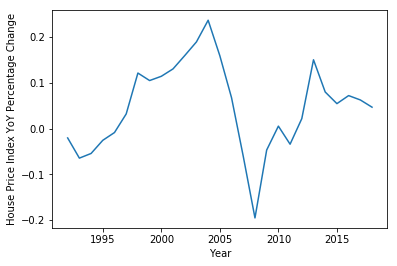

--------------
Atlanta-Sandy Springs-Roswell, GA


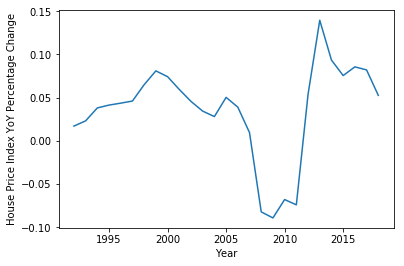

--------------
Austin-Round Rock, TX


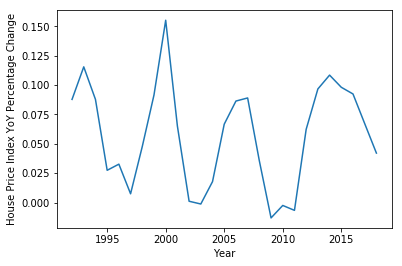

--------------
Bakersfield, CA


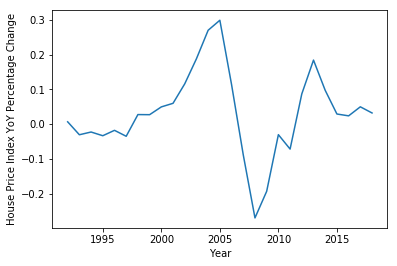

--------------
Baltimore-Columbia-Towson, MD


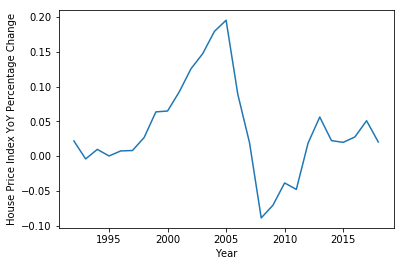

--------------
Baton Rouge, LA


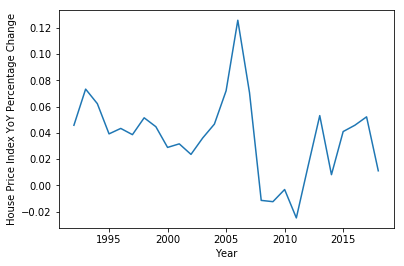

--------------
Birmingham-Hoover, AL


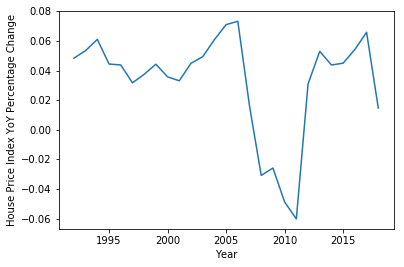

--------------
Boise City, ID


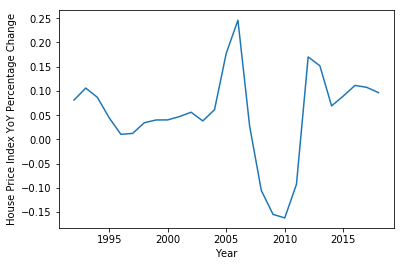

--------------
Boston, MA (MSAD)


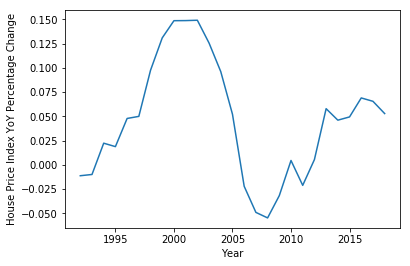

--------------
Bridgeport-Stamford-Norwalk, CT


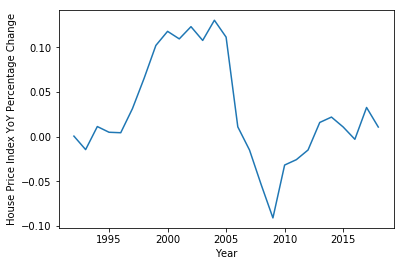

--------------
Buffalo-Cheektowaga-Niagara Falls, NY


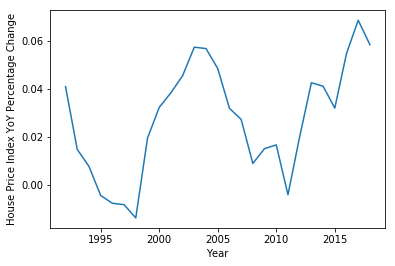

--------------
Cambridge-Newton-Framingham, MA (MSAD)


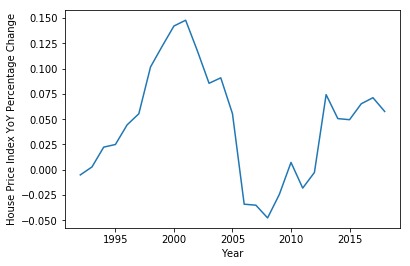

--------------
Camden, NJ (MSAD)


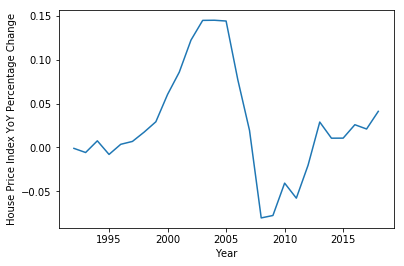

--------------
Cape Coral-Fort Myers, FL


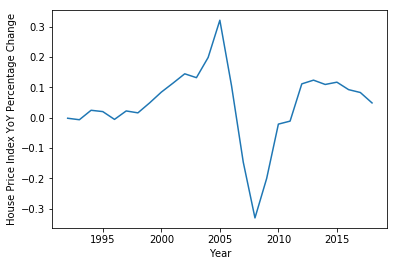

--------------
Charleston-North Charleston, SC


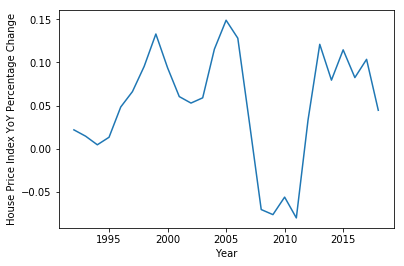

--------------
Charlotte-Concord-Gastonia, NC-SC


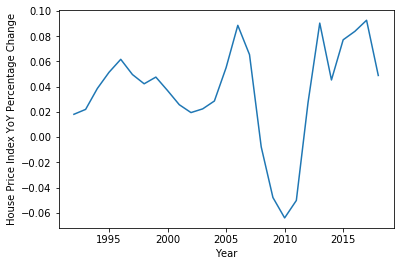

--------------
Chicago-Naperville-Arlington Heights, IL (MSAD)


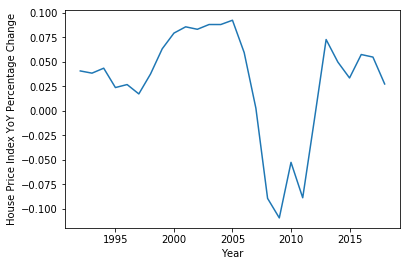

--------------
Cincinnati, OH-KY-IN


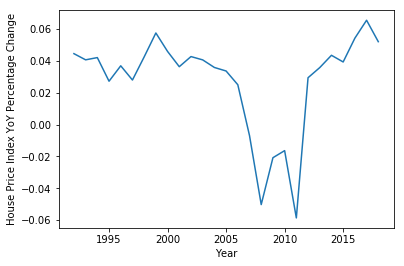

--------------
Cleveland-Elyria, OH


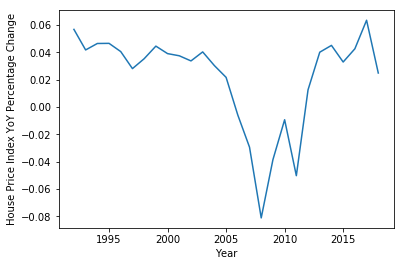

--------------
Colorado Springs, CO


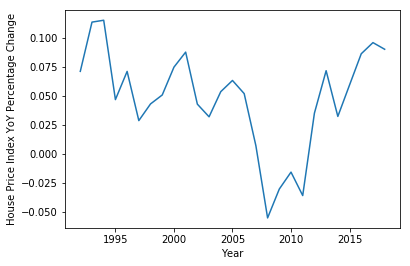

--------------
Columbia, SC


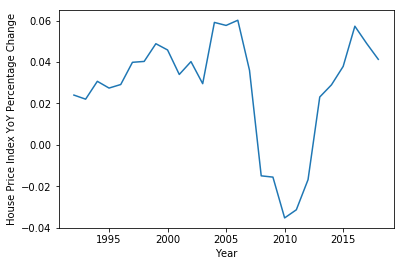

--------------
Columbus, OH


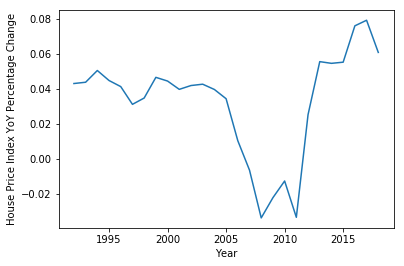

--------------
Dallas-Plano-Irving, TX (MSAD)


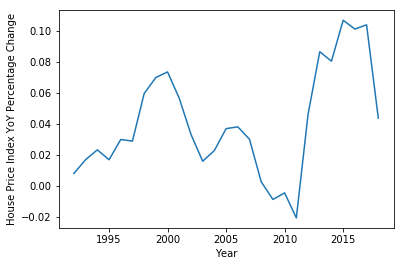

--------------
Dayton, OH


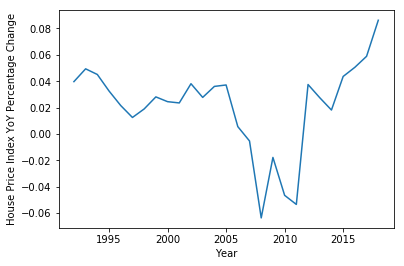

--------------
Denver-Aurora-Lakewood, CO


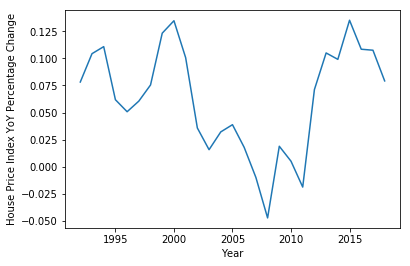

--------------
Detroit-Dearborn-Livonia, MI (MSAD)


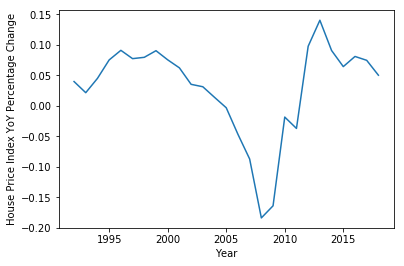

--------------
El Paso, TX


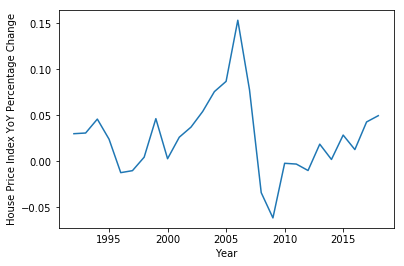

--------------
Elgin, IL (MSAD)


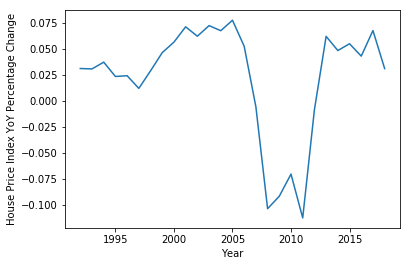

--------------
Fort Lauderdale-Pompano Beach-Deerfield Beach, FL (MSAD)


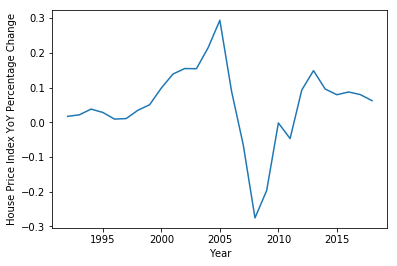

--------------
Fort Worth-Arlington, TX (MSAD)


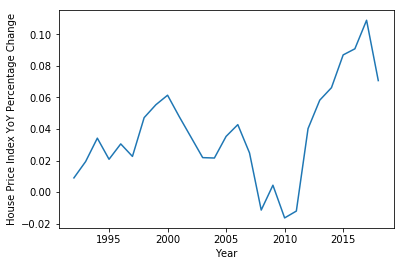

--------------
Fresno, CA


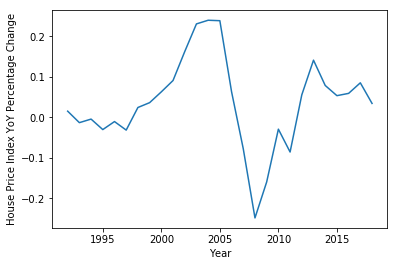

--------------
Gary, IN (MSAD)


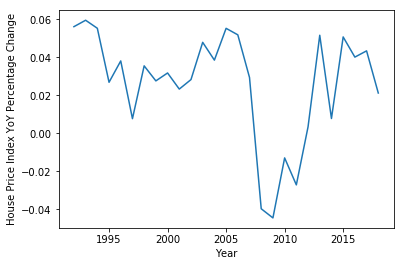

--------------
Grand Rapids-Wyoming, MI


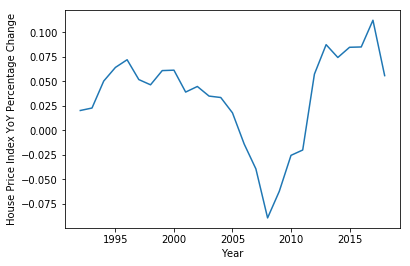

--------------
Greensboro-High Point, NC


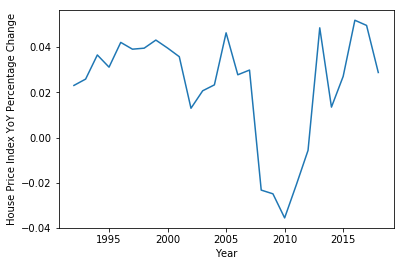

--------------
Greenville-Anderson-Mauldin, SC


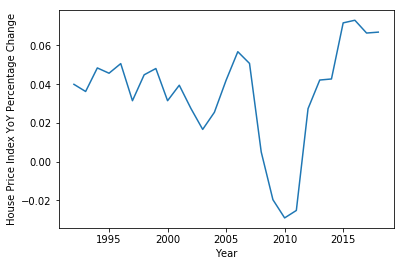

--------------
Hartford-West Hartford-East Hartford, CT


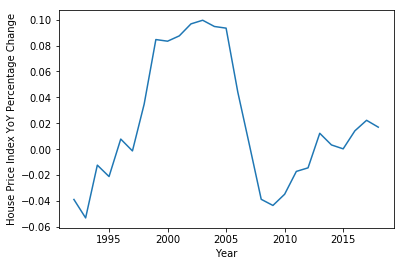

--------------
Honolulu ('Urban Honolulu'), HI


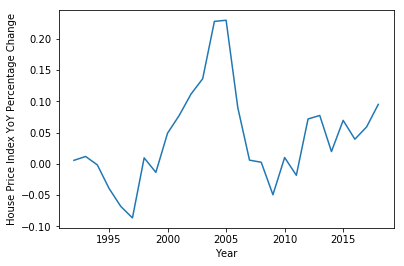

--------------
Houston-The Woodlands-Sugar Land, TX


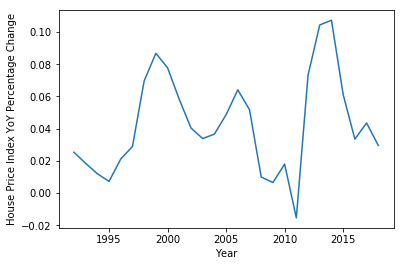

--------------
Indianapolis-Carmel-Anderson, IN


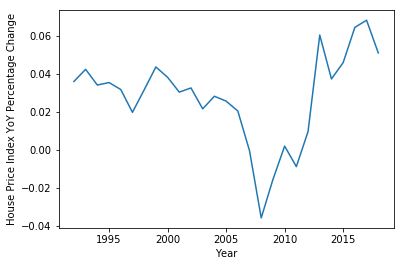

--------------
Jacksonville, FL


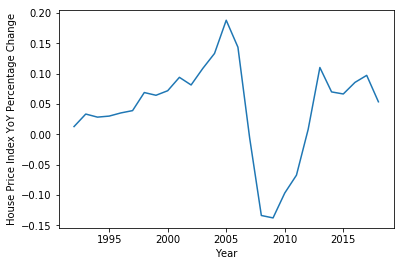

--------------
Kansas City, MO-KS


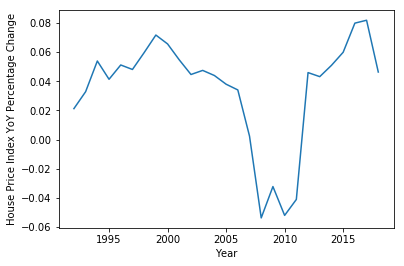

--------------
Knoxville, TN


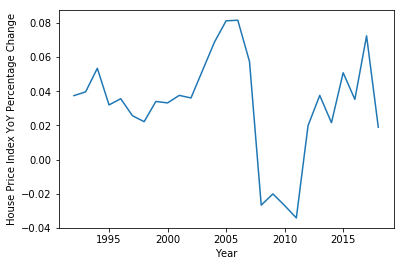

--------------
Lake County-Kenosha County, IL-WI (MSAD)


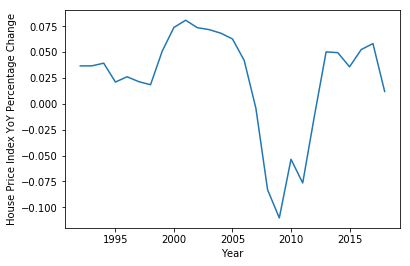

--------------
Las Vegas-Henderson-Paradise, NV


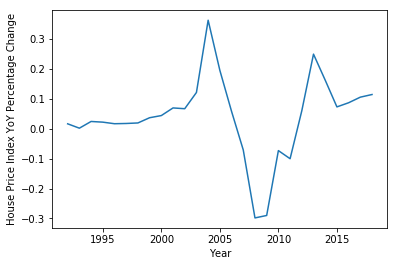

--------------
Little Rock-North Little Rock-Conway, AR


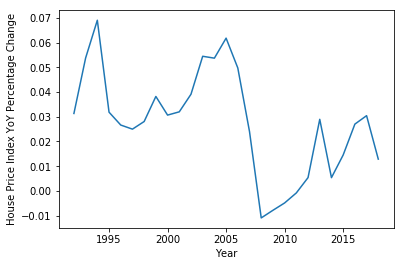

--------------
Los Angeles-Long Beach-Glendale, CA (MSAD)


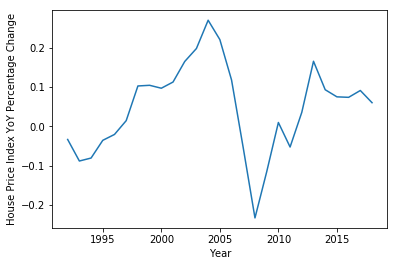

--------------
Louisville/Jefferson County, KY-IN


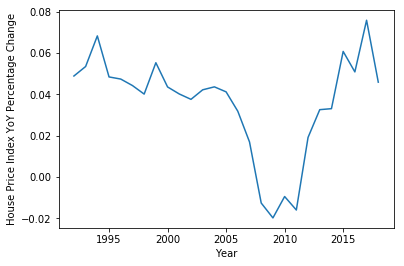

--------------
Memphis, TN-MS-AR


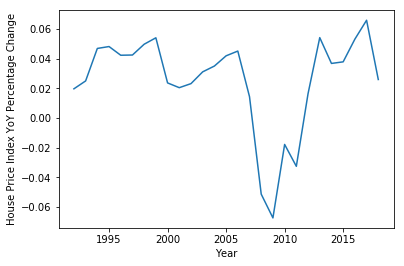

--------------
Miami-Miami Beach-Kendall, FL (MSAD)


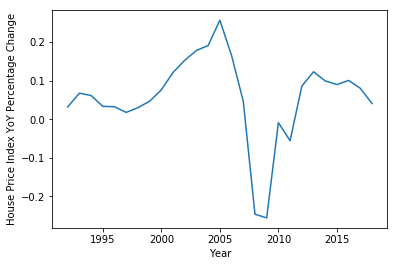

--------------
Milwaukee-Waukesha-West Allis, WI


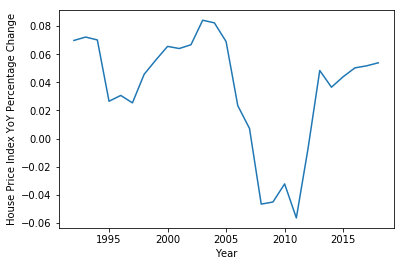

--------------
Minneapolis-St. Paul-Bloomington, MN-WI


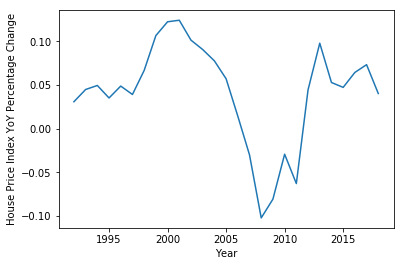

--------------
Montgomery County-Bucks County-Chester County, PA (MSAD)


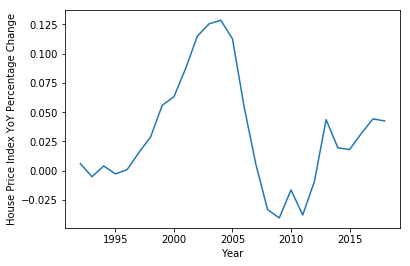

--------------
Nashville-Davidson--Murfreesboro--Franklin, TN


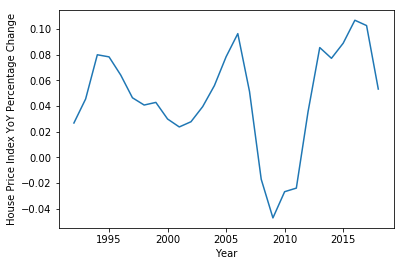

--------------
Nassau County-Suffolk County, NY (MSAD)


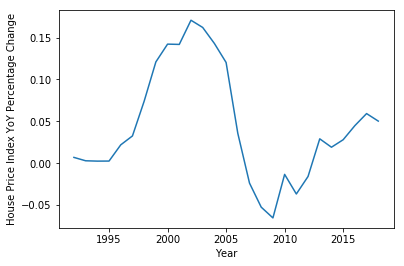

--------------
New Haven-Milford, CT


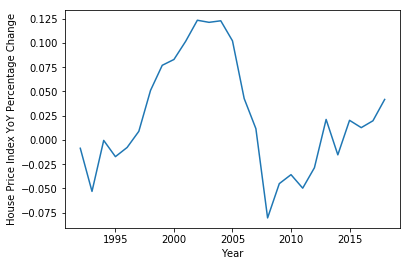

--------------
New Orleans-Metairie, LA


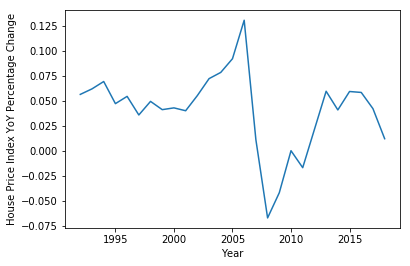

--------------
New York-Jersey City-White Plains, NY-NJ (MSAD)


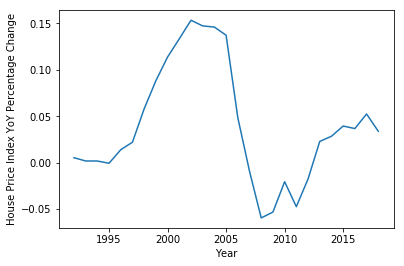

--------------
Newark, NJ-PA (MSAD)


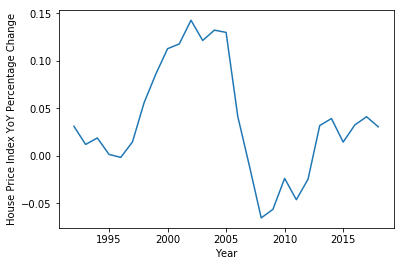

--------------
North Port-Sarasota-Bradenton, FL


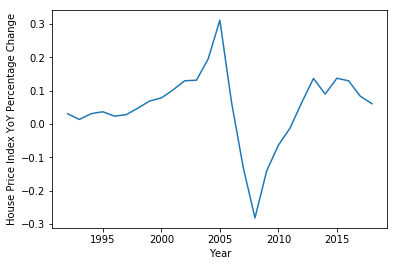

--------------
Oakland-Hayward-Berkeley, CA (MSAD)


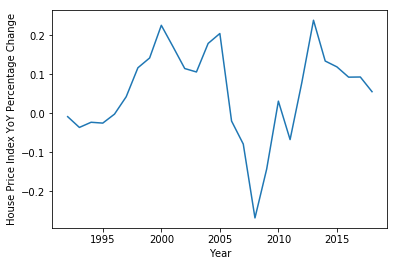

--------------
Oklahoma City, OK


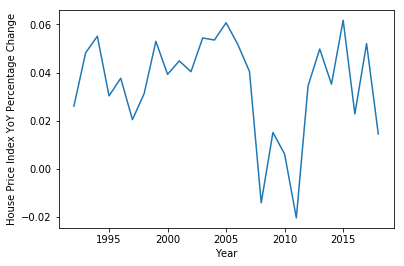

--------------
Omaha-Council Bluffs, NE-IA


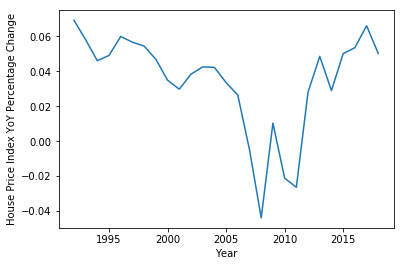

--------------
Orlando-Kissimmee-Sanford, FL


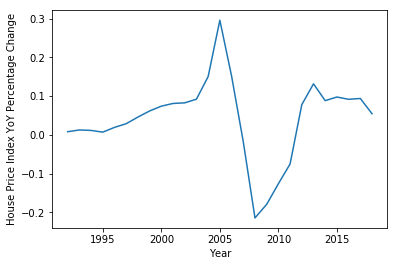

--------------
Oxnard-Thousand Oaks-Ventura, CA


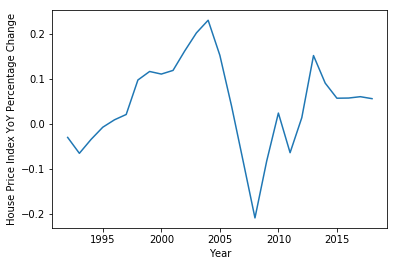

--------------
Philadelphia, PA (MSAD)


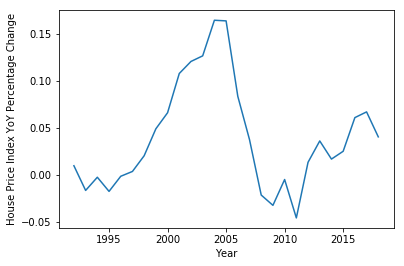

--------------
Phoenix-Mesa-Scottsdale, AZ


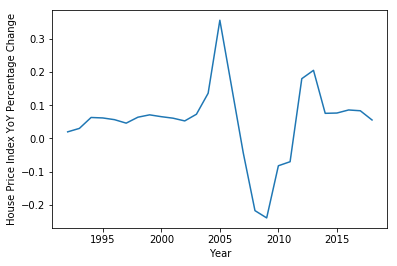

--------------
Pittsburgh, PA


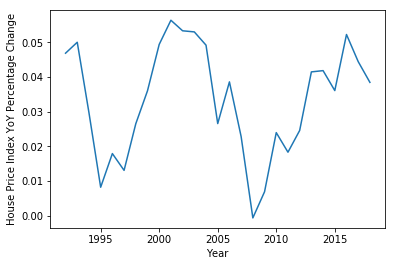

--------------
Portland-Vancouver-Hillsboro, OR-WA


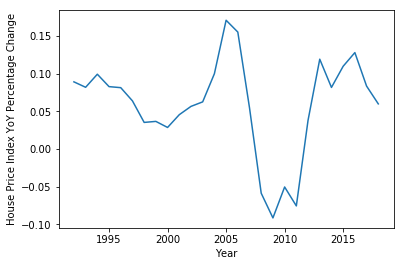

--------------
Providence-Warwick, RI-MA


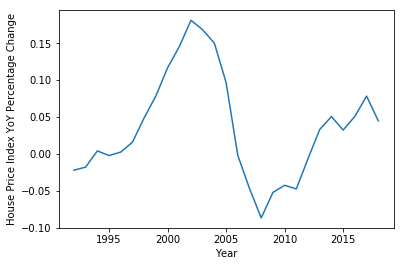

--------------
Raleigh, NC


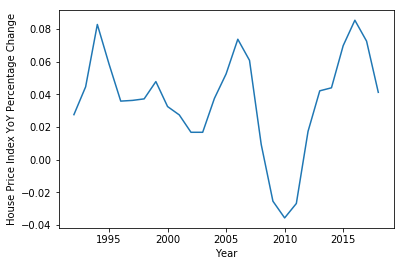

--------------
Richmond, VA


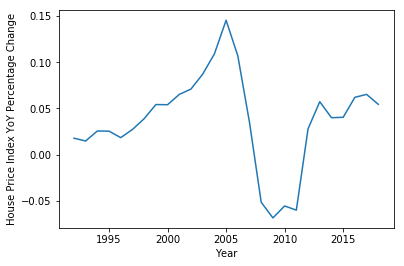

--------------
Riverside-San Bernardino-Ontario, CA


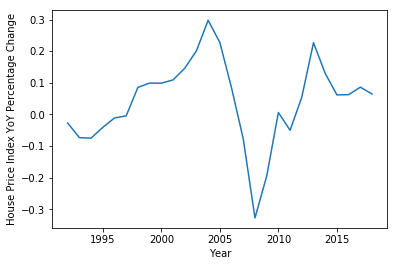

--------------
Rochester, NY


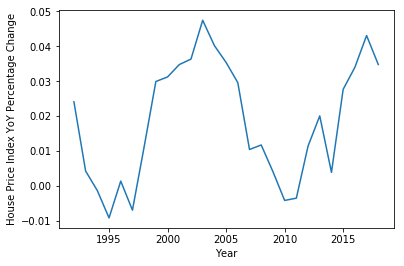

--------------
Sacramento--Roseville--Arden-Arcade, CA


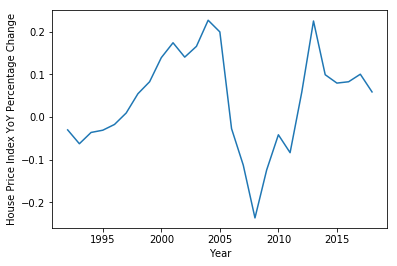

--------------
Salt Lake City, UT


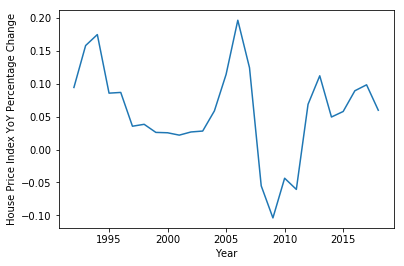

--------------
San Antonio-New Braunfels, TX


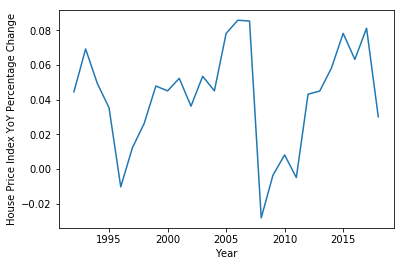

--------------
San Diego-Carlsbad, CA


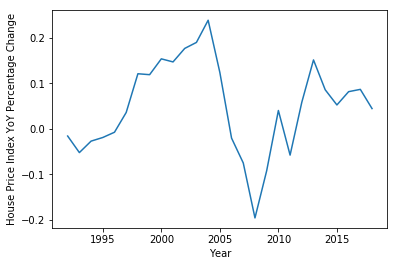

--------------
San Francisco-Redwood City-South San Francisco, CA (MSAD)


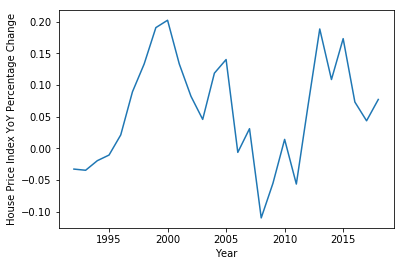

--------------
San Jose-Sunnyvale-Santa Clara, CA


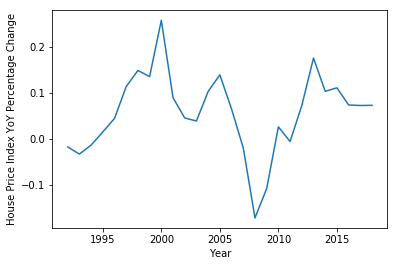

--------------
Seattle-Bellevue-Everett, WA (MSAD)


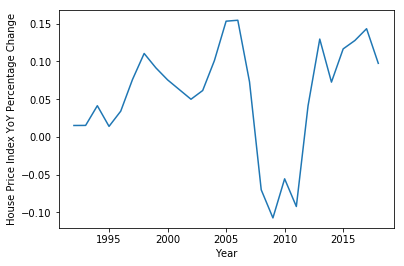

--------------
Silver Spring-Frederick-Rockville, MD (MSAD)


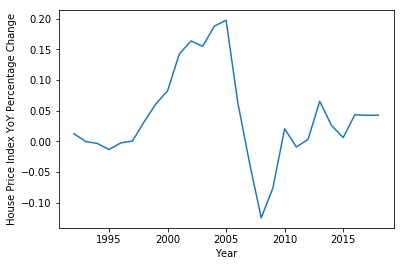

--------------
St. Louis, MO-IL


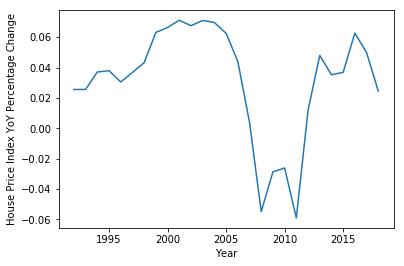

--------------
Stockton-Lodi, CA


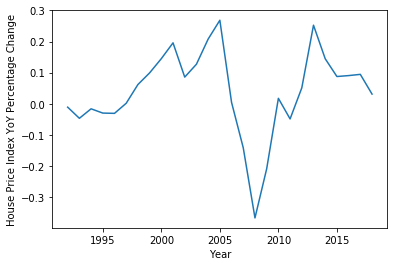

--------------
Syracuse, NY


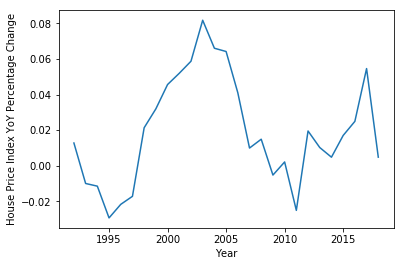

--------------
Tacoma-Lakewood, WA (MSAD)


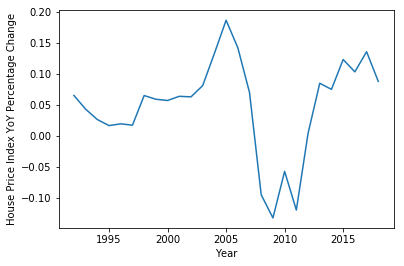

--------------
Tampa-St. Petersburg-Clearwater, FL


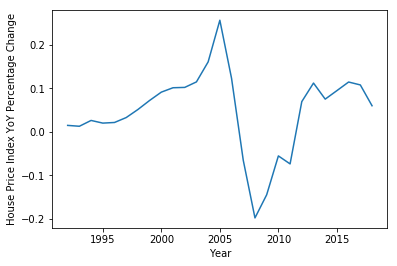

--------------
Tucson, AZ


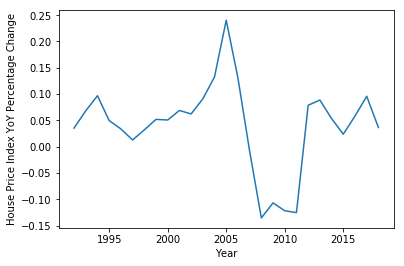

--------------
Tulsa, OK


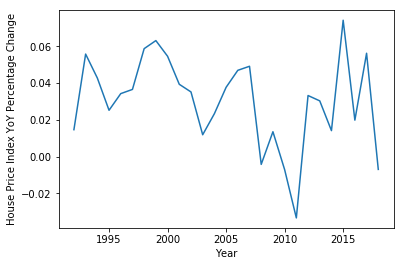

--------------
Virginia Beach-Norfolk-Newport News, VA-NC


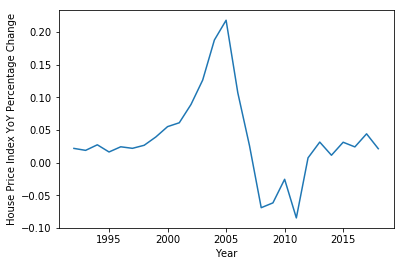

--------------
Warren-Troy-Farmington Hills, MI (MSAD)


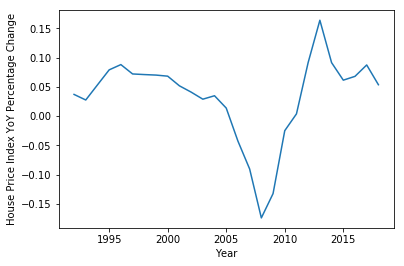

--------------
Washington-Arlington-Alexandria, DC-VA-MD-WV (MSAD)


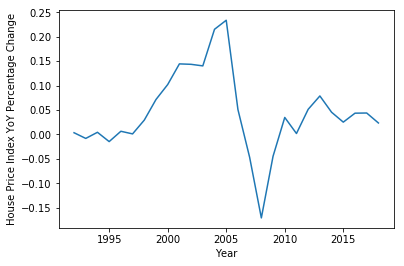

--------------
West Palm Beach-Boca Raton-Delray Beach, FL (MSAD)


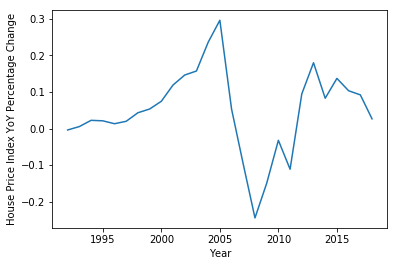

--------------
Wichita, KS


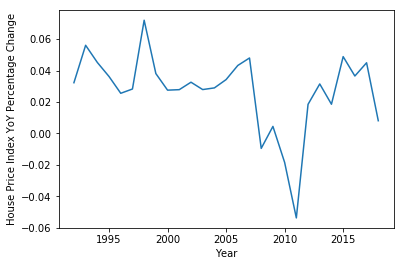

--------------
Wilmington, DE-MD-NJ (MSAD)


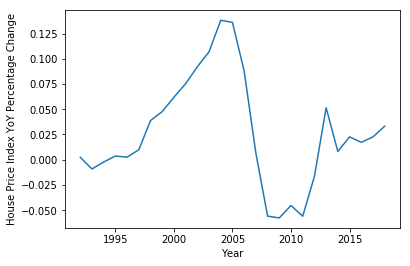

--------------
Winston-Salem, NC


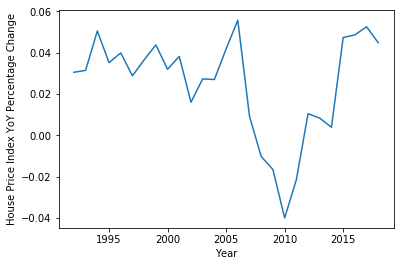

--------------
Worcester, MA-CT


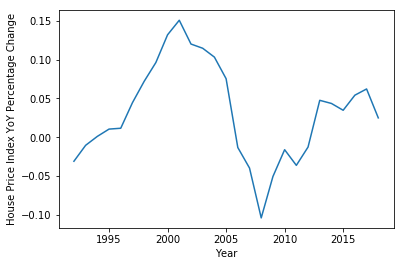

--------------


In [247]:
# HPI percentage change YoY for each city from 1991 to 2018
for city in HPI_3.columns.tolist():
    print(city)
    city_percentage = HPI_3[city]
    d = city_percentage.plot(kind='line')
    d.set_xlabel('Year')
    d.set_ylabel('House Price Index YoY Percentage Change')
    plt.show()
    print('--------------')

In [248]:
# Homeownership Rates percent change analysis
ho_rates_change = ho_rates_pivot.pct_change()

for i in range(2006, 2018):
    print(i)
    percentage_change = ho_rates_change.loc[i]
    print(percentage_change)

2006
MSA
Akron, OH                                         -1.121076e-02
Albany-Schenectady-Troy, NY                        1.017332e-02
Albuquerque, NM                                    1.010466e-02
Allentown-Bethlehem-Easton, PA-NJ                  2.210884e-02
Atlanta-Sandy Springs-Marietta, GA\1               2.335217e-02
Austin-Round Rock, TX\2                            4.386996e-02
Bakersfield, CA                                    2.811079e-02
Baltimore-Towson, MD\3                             3.255485e-02
Baton Rouge, LA                                   -8.159661e-02
Birmingham-Hoover, AL\4                            1.331115e-02
Boston-Cambridge-Quincy, MA-NH\5                   2.659786e-02
Bridgeport-Stamford-Norwalk, CT                    3.031410e-02
Buffalo-Cheektowaga-Tonawanda, NY\6               -2.220446e-16
Charlotte-Gastonia-Concord, NC-SC\7                4.559271e-03
Chicago-Naperville-Joliet, IL\8                   -5.357143e-03
Cincinnati-Middletown, OH-KY-IN

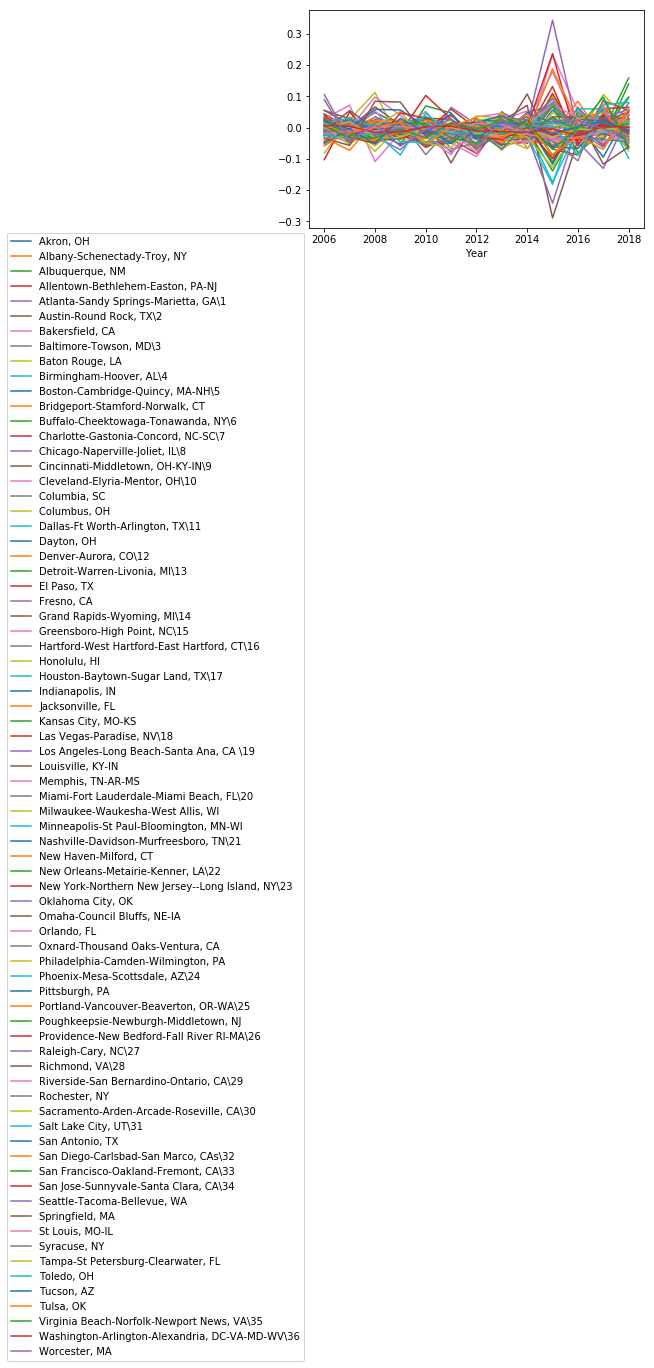

In [249]:
# Homeownership Rates percentage change YoY for all cities from 2006 to 2018
ho_rates_change.plot(kind='line')
plt.legend(bbox_to_anchor=(0,0))

plt.show()

Akron, OH 


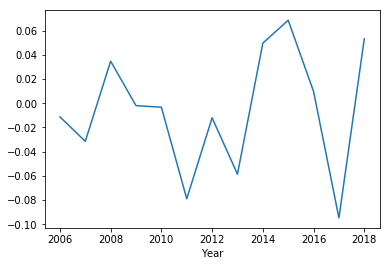

Albany-Schenectady-Troy, NY 


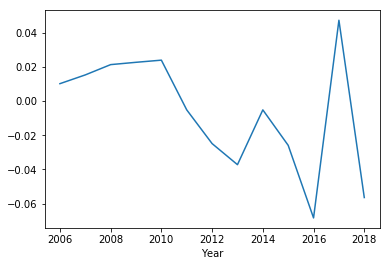

Albuquerque, NM


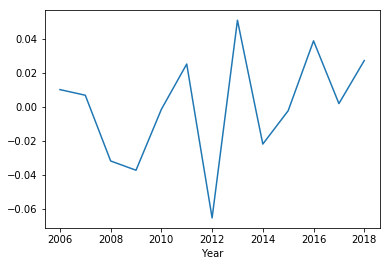

Allentown-Bethlehem-Easton, PA-NJ


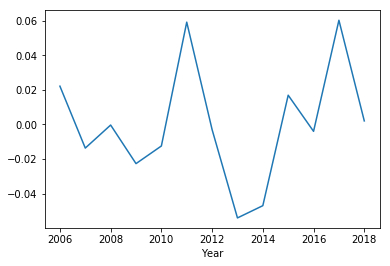

Atlanta-Sandy Springs-Marietta, GA\1


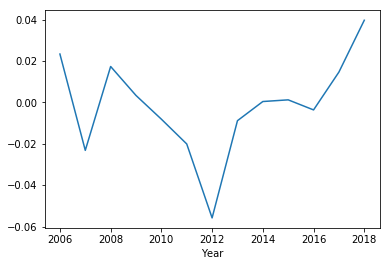

Austin-Round Rock, TX\2


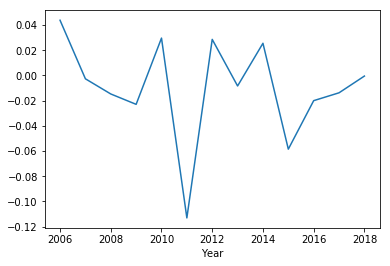

Bakersfield, CA


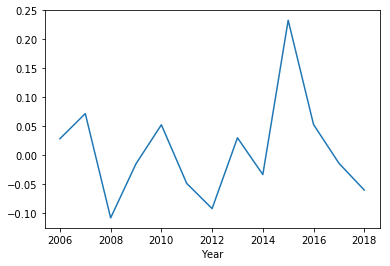

Baltimore-Towson, MD\3


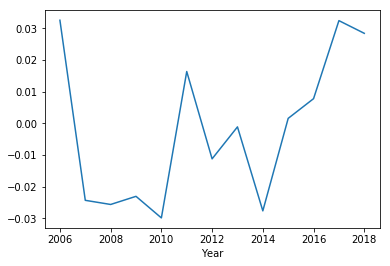

Baton Rouge, LA


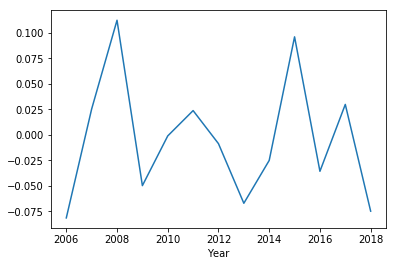

Birmingham-Hoover, AL\4


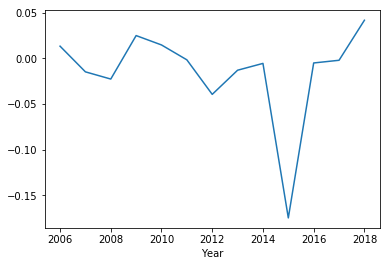

Boston-Cambridge-Quincy, MA-NH\5


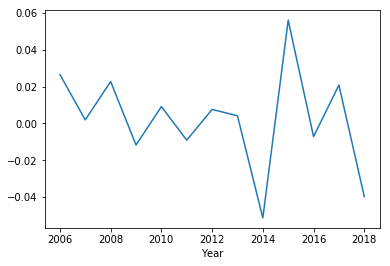

Bridgeport-Stamford-Norwalk, CT


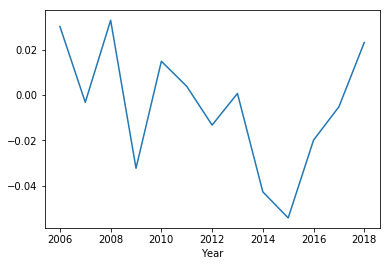

Buffalo-Cheektowaga-Tonawanda, NY\6


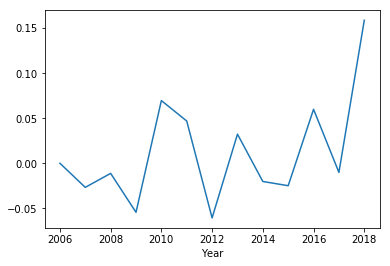

Charlotte-Gastonia-Concord, NC-SC\7


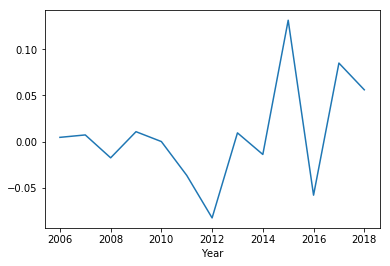

Chicago-Naperville-Joliet, IL\8


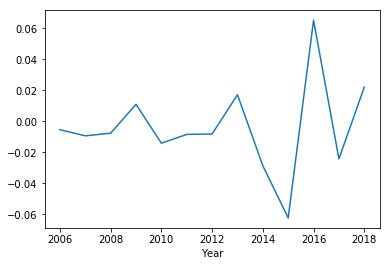

Cincinnati-Middletown, OH-KY-IN\9


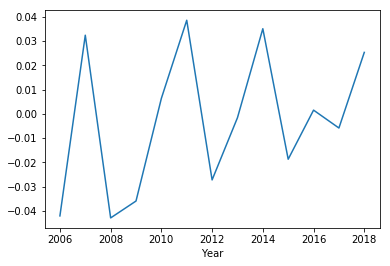

Cleveland-Elyria-Mentor, OH\10


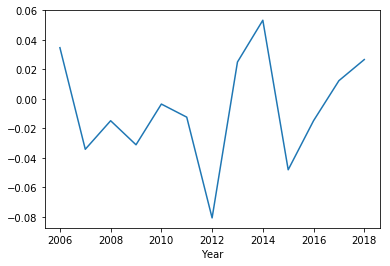

Columbia, SC


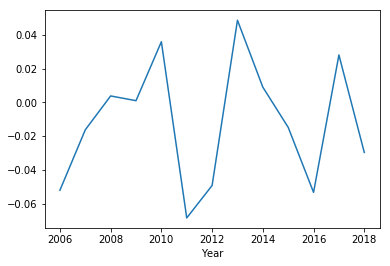

Columbus, OH


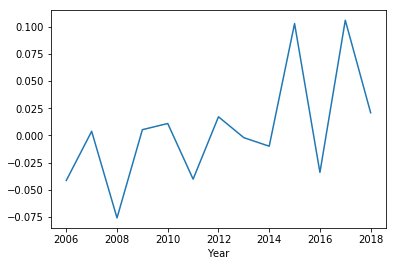

Dallas-Ft Worth-Arlington, TX\11


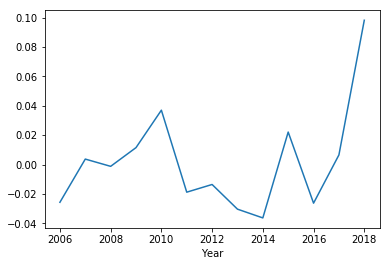

Dayton, OH


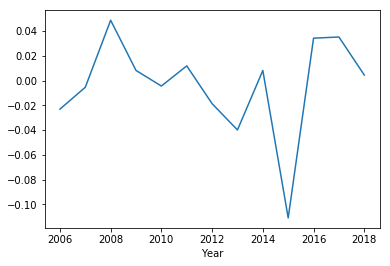

Denver-Aurora, CO\12


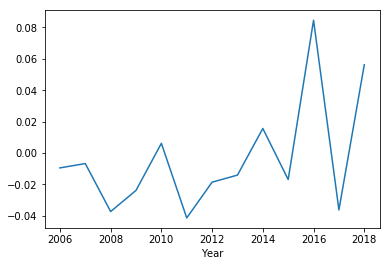

Detroit-Warren-Livonia, MI\13


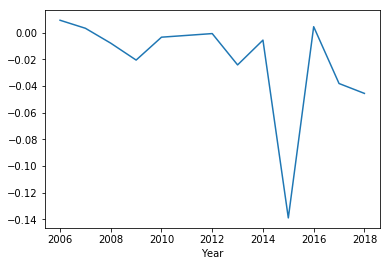

El Paso, TX


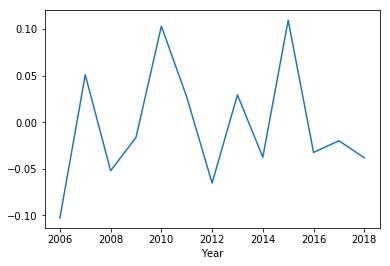

Fresno, CA


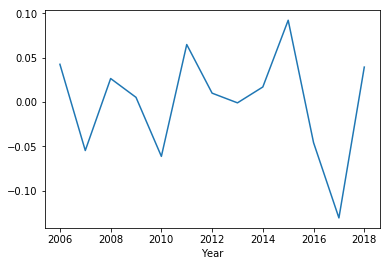

Grand Rapids-Wyoming, MI\14


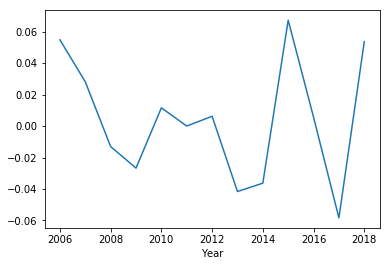

Greensboro-High Point, NC\15


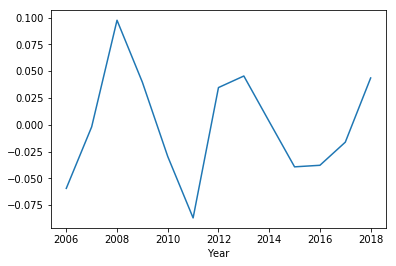

Hartford-West Hartford-East Hartford, CT\16


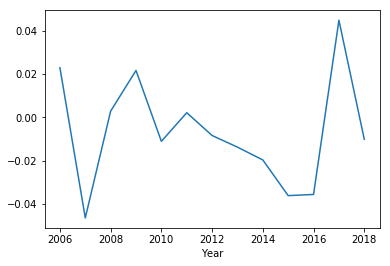

Honolulu, HI


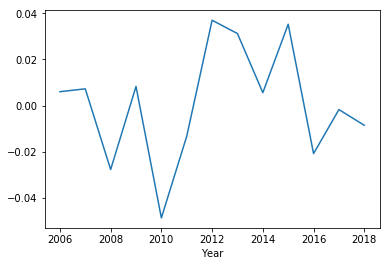

Houston-Baytown-Sugar Land, TX\17


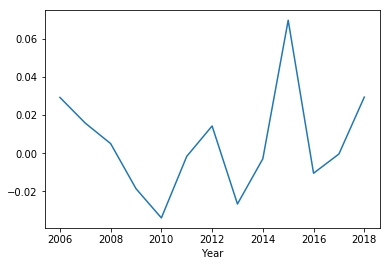

Indianapolis, IN


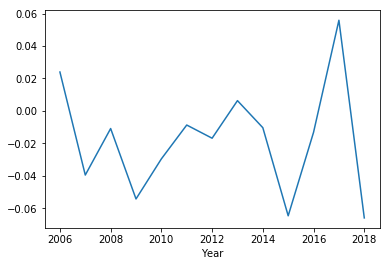

Jacksonville, FL


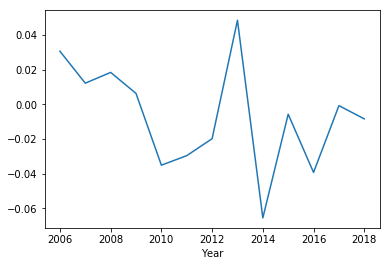

Kansas City, MO-KS


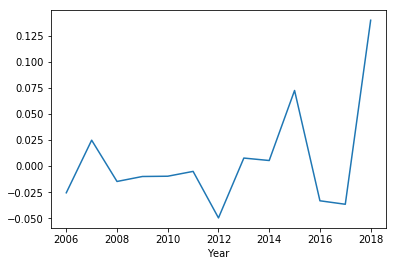

Las Vegas-Paradise, NV\18


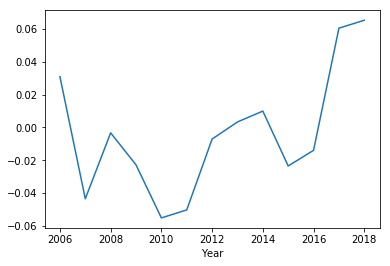

Los Angeles-Long Beach-Santa Ana, CA \19


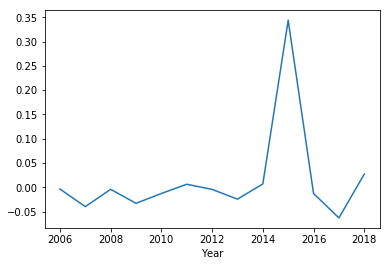

Louisville, KY-IN


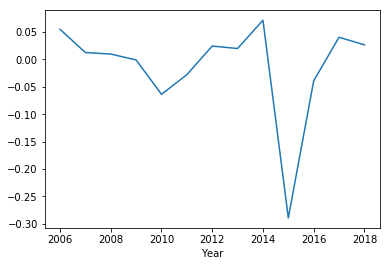

Memphis, TN-AR-MS


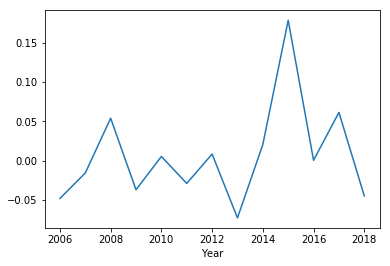

Miami-Fort Lauderdale-Miami Beach, FL\20


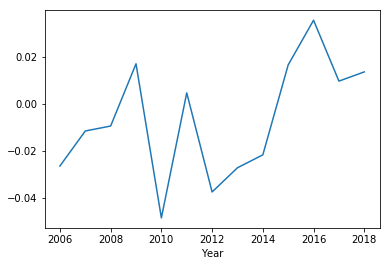

Milwaukee-Waukesha-West Allis, WI


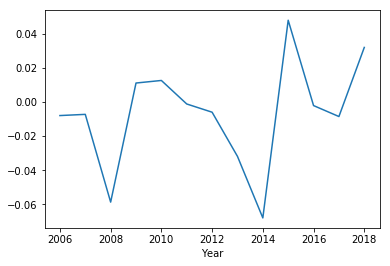

Minneapolis-St Paul-Bloomington, MN-WI 


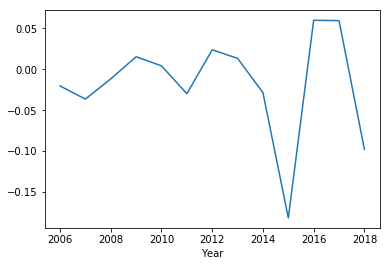

Nashville-Davidson-Murfreesboro, TN\21


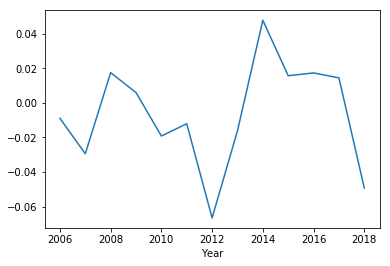

New Haven-Milford, CT


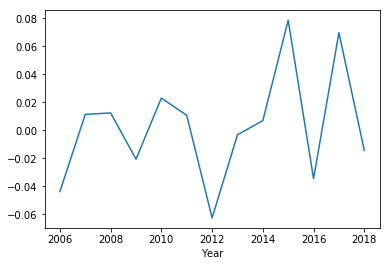

New Orleans-Metairie-Kenner, LA\22


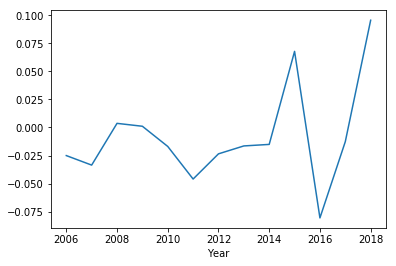

New York-Northern New Jersey--Long Island, NY\23


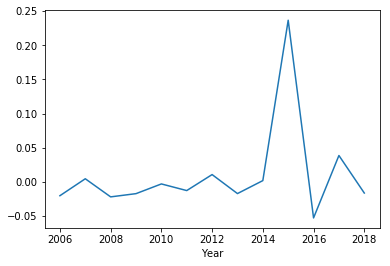

Oklahoma City, OK


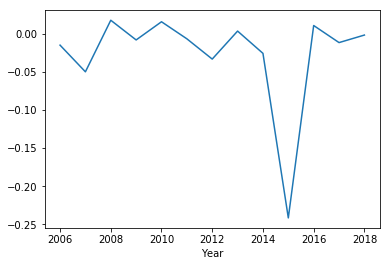

Omaha-Council Bluffs, NE-IA


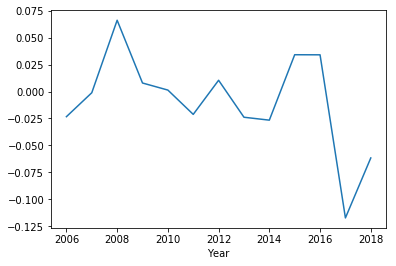

Orlando, FL


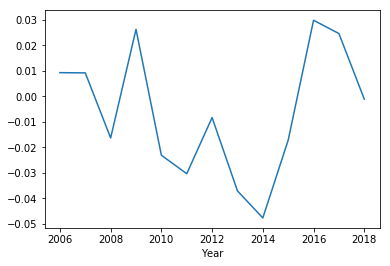

Oxnard-Thousand Oaks-Ventura, CA


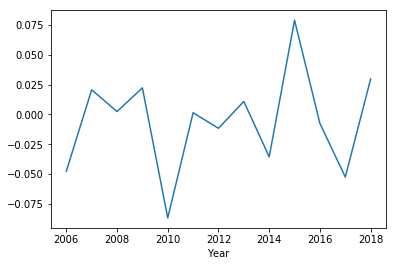

Philadelphia-Camden-Wilmington, PA 


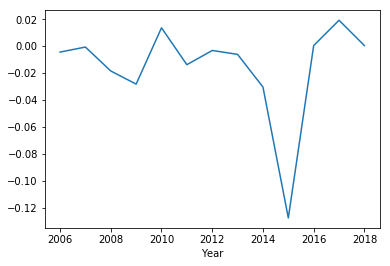

Phoenix-Mesa-Scottsdale, AZ\24


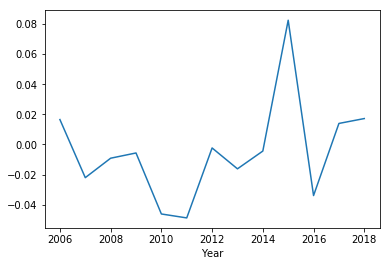

Pittsburgh, PA


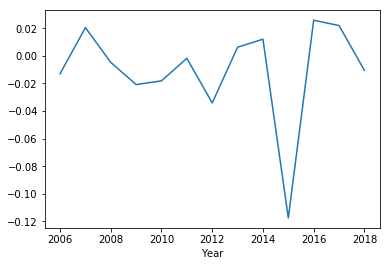

Portland-Vancouver-Beaverton, OR-WA\25


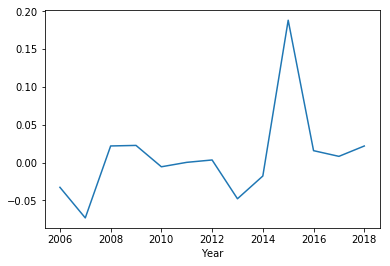

Poughkeepsie-Newburgh-Middletown, NJ


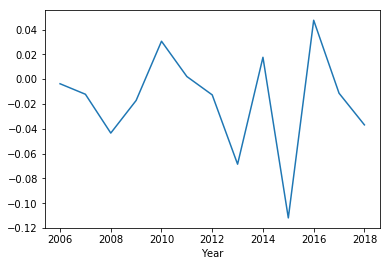

Providence-New Bedford-Fall River RI-MA\26


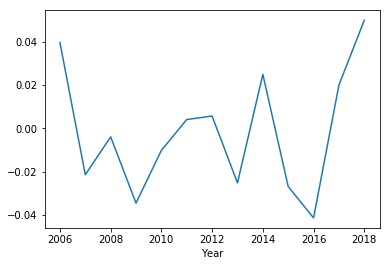

Raleigh-Cary, NC\27


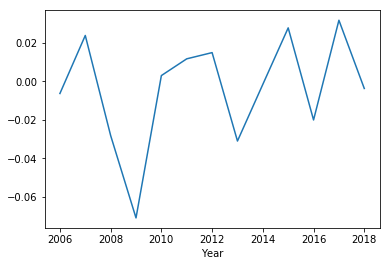

Richmond, VA\28


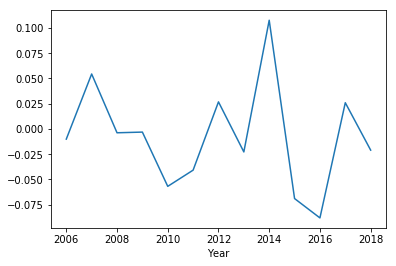

Riverside-San Bernardino-Ontario, CA\29


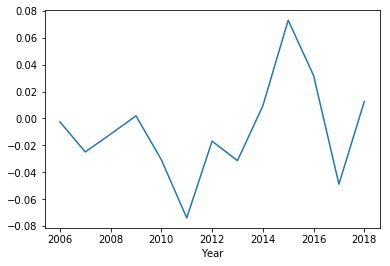

Rochester, NY


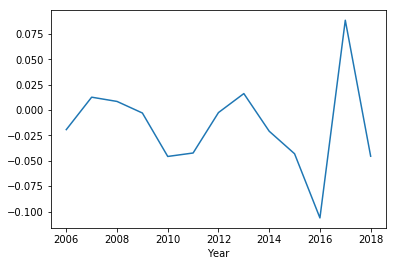

Sacramento-Arden-Arcade-Roseville, CA\30


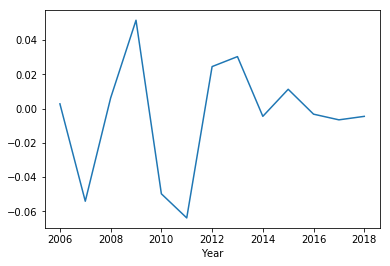

Salt Lake City, UT\31


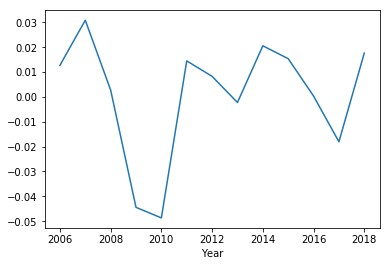

San Antonio, TX 


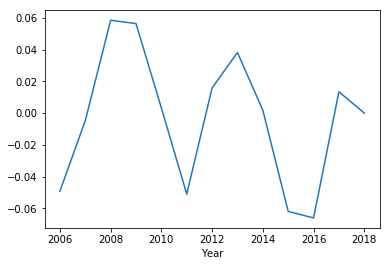

San Diego-Carlsbad-San Marco, CAs\32


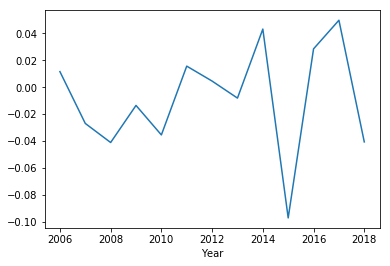

San Francisco-Oakland-Fremont, CA\33


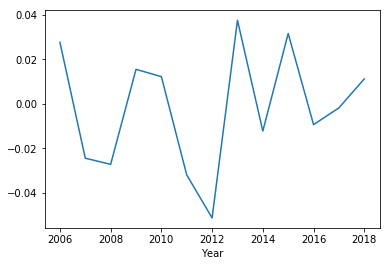

San Jose-Sunnyvale-Santa Clara, CA\34


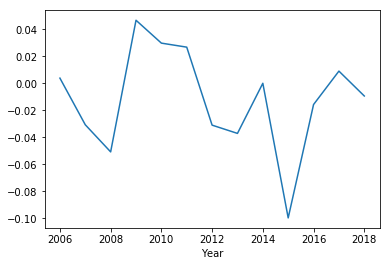

Seattle-Tacoma-Bellevue, WA


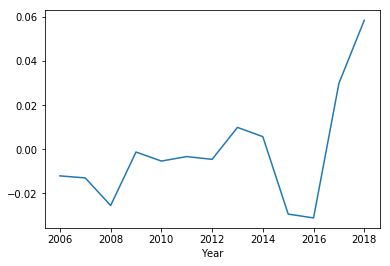

Springfield, MA


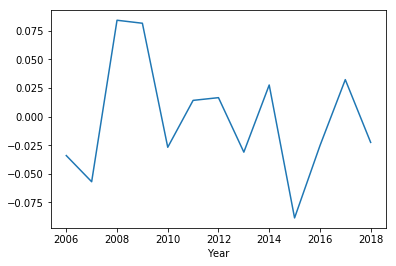

St Louis, MO-IL


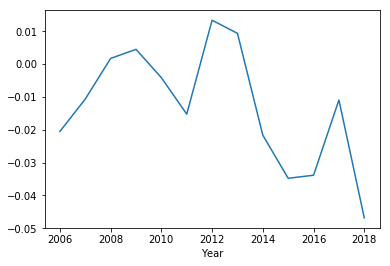

Syracuse, NY


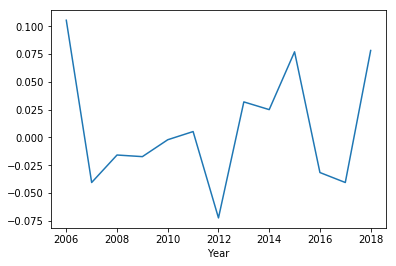

Tampa-St Petersburg-Clearwater, FL


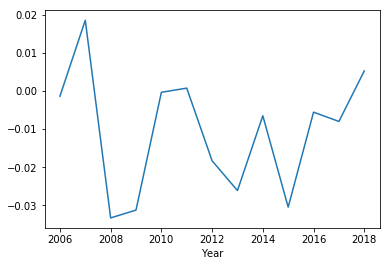

Toledo, OH


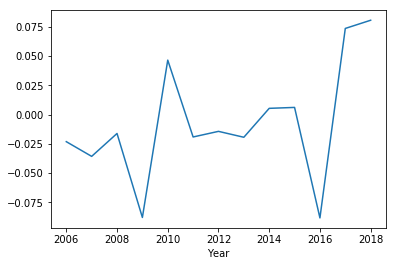

Tucson, AZ 


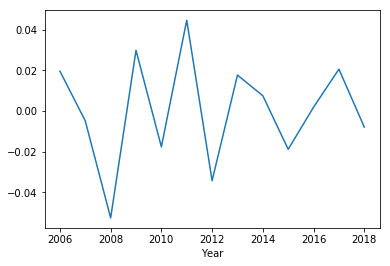

Tulsa, OK


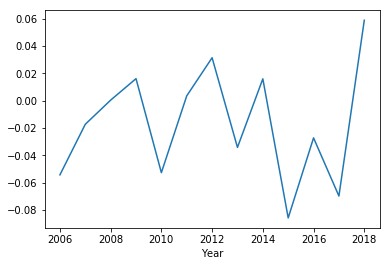

Virginia Beach-Norfolk-Newport News, VA\35


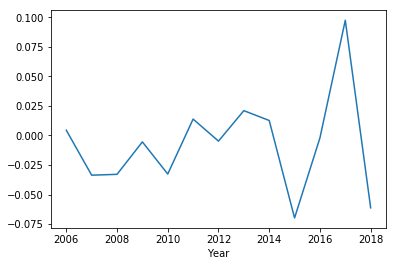

Washington-Arlington-Alexandria, DC-VA-MD-WV\36


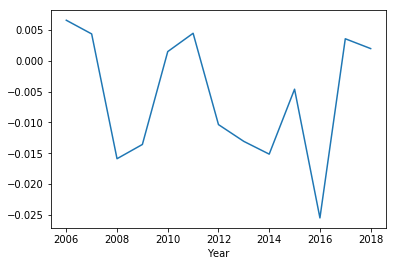

Worcester, MA


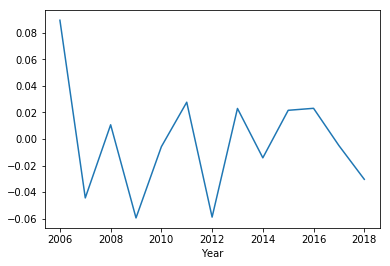

In [250]:
# HO percentage change YoY for each city from 2006 to 2018
for MSA in ho_rates_change.columns.tolist():
    print(MSA)
    MSA_percentage = ho_rates_change[MSA]
    MSA_percentage.plot(kind='line')
    
    plt.show()

In [251]:
# Vacancy Rates percentage change analysis
vacancy_change = vacancy.pct_change()

for i in range(2006,2018):
    print(i)
    percentage_change = vacancy_change.loc[i]
    print(percentage_change)

2006
MSA
Akron, OH                                          0.505882
Albany-Schenectady-Troy, NY                       -0.246914
Albuquerque, NM                                    0.126761
Allentown-Bethlehem-Easton, PA-NJ                  0.826087
Atlanta-Sandy Springs-Marietta, GA\1               0.139706
Austin-Round Rock, TX\2                           -0.360825
Bakersfield, CA                                    0.586207
Baltimore-Towson, MD\3                             0.616667
Baton Rouge, LA                                   -0.579545
Birmingham-Hoover, AL\4                            0.781250
Boston-Cambridge-Quincy, MA-NH\5                   0.591837
Bridgeport-Stamford-Norwalk, CT                    2.283019
Buffalo-Cheektowaga-Tonawanda, NY\6                0.034483
Charlotte-Gastonia-Concord, NC-SC\7                0.263736
Chicago-Naperville-Joliet, IL\8                    0.223684
Cincinnati-Middletown, OH-KY-IN\9                  0.413043
Cleveland-Elyria-Mentor, OH\10 

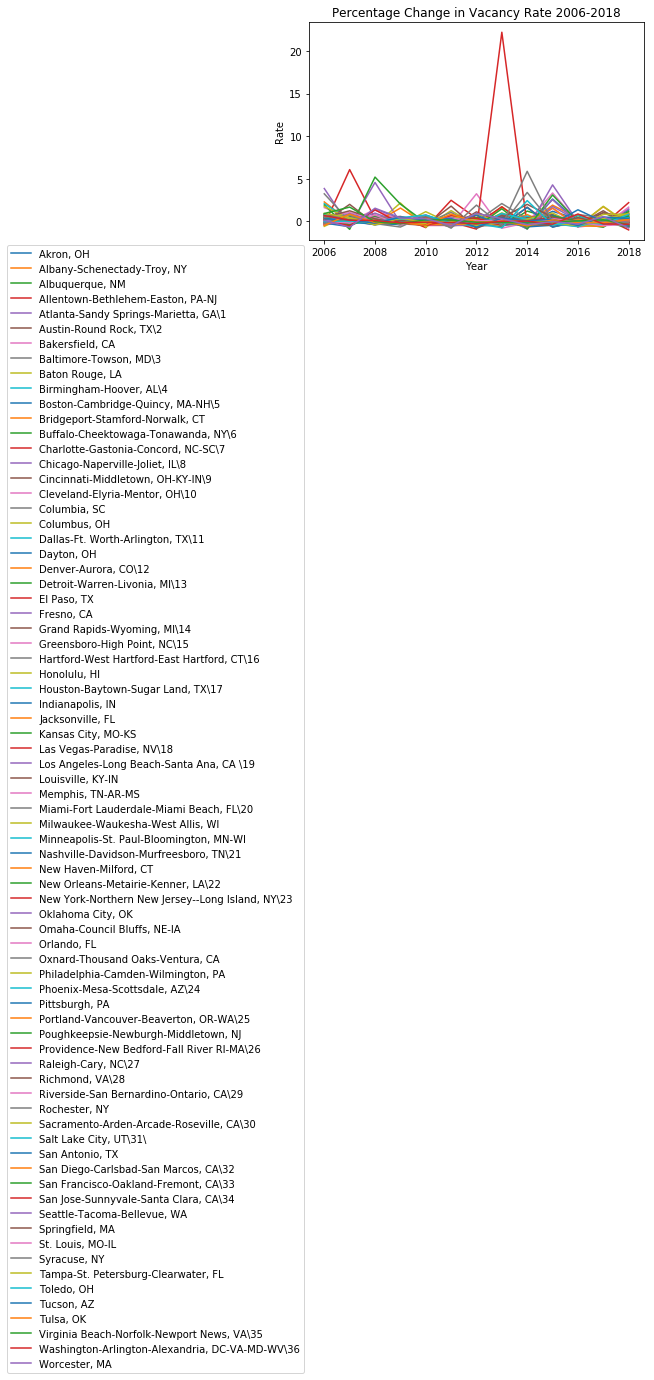

In [252]:
# Homeownership Rates percentage change YoY for all cities from 2006 to 2018
ax = vacancy_change.plot(kind = 'line')
plt.legend(bbox_to_anchor=(0, 0))
plt.title("Percentage Change in Vacancy Rate 2006-2018")
ax.set_ylabel("Rate")
plt.show()

Akron, OH 


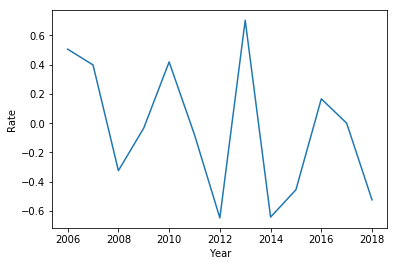

--------------
Albany-Schenectady-Troy, NY 


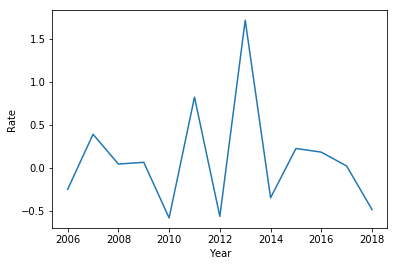

--------------
Albuquerque, NM


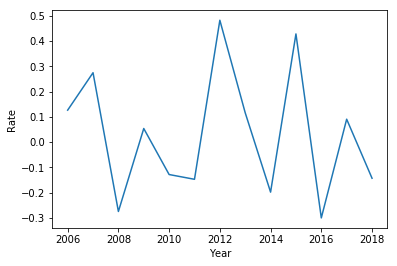

--------------
Allentown-Bethlehem-Easton, PA-NJ


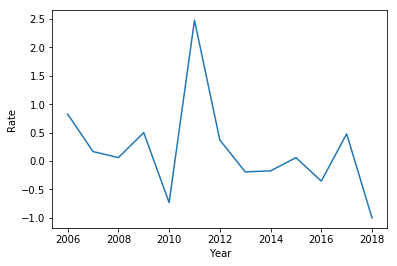

--------------
Atlanta-Sandy Springs-Marietta, GA\1


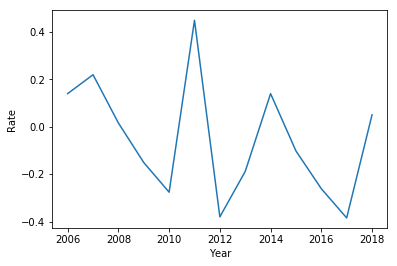

--------------
Austin-Round Rock, TX\2


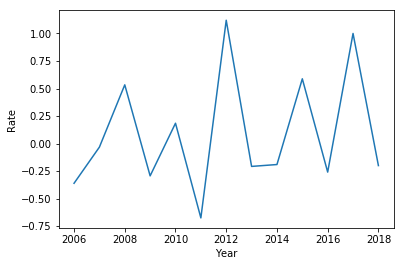

--------------
Bakersfield, CA


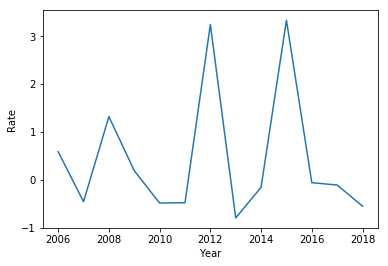

--------------
Baltimore-Towson, MD\3


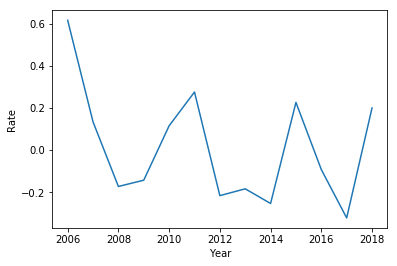

--------------
Baton Rouge, LA


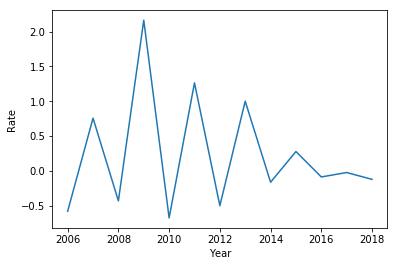

--------------
Birmingham-Hoover, AL\4


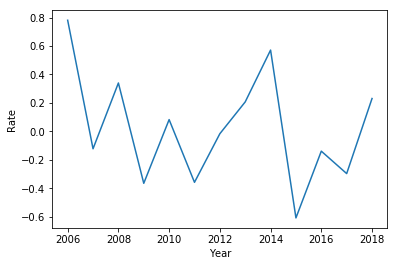

--------------
Boston-Cambridge-Quincy, MA-NH\5


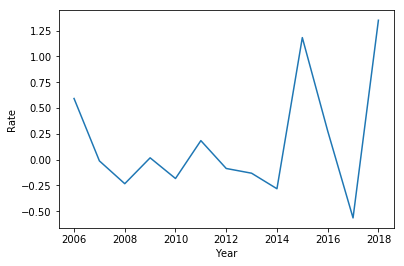

--------------
Bridgeport-Stamford-Norwalk, CT


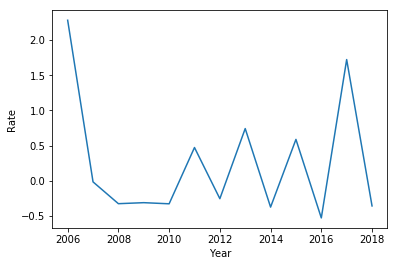

--------------
Buffalo-Cheektowaga-Tonawanda, NY\6


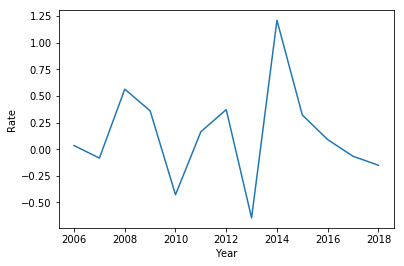

--------------
Charlotte-Gastonia-Concord, NC-SC\7


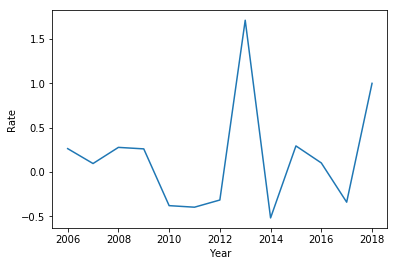

--------------
Chicago-Naperville-Joliet, IL\8


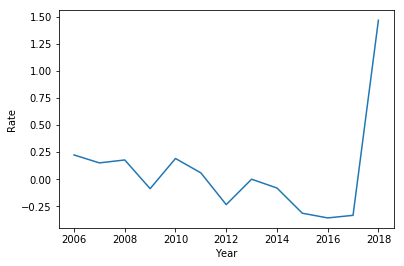

--------------
Cincinnati-Middletown, OH-KY-IN\9


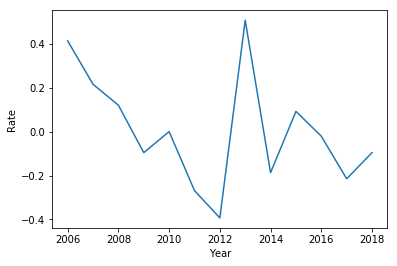

--------------
Cleveland-Elyria-Mentor, OH\10


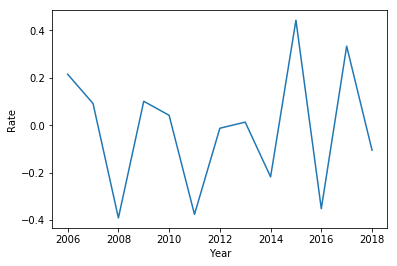

--------------
Columbia, SC


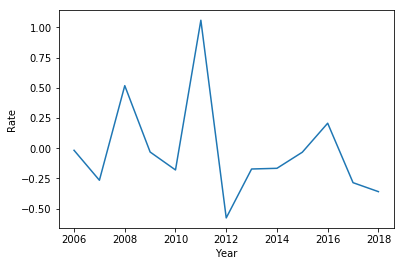

--------------
Columbus, OH


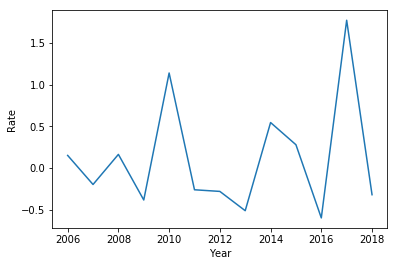

--------------
Dallas-Ft. Worth-Arlington, TX\11


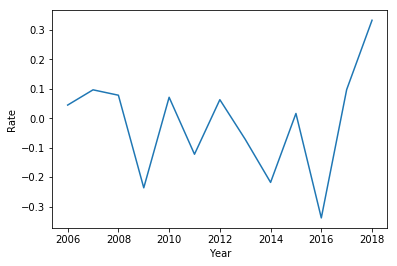

--------------
Dayton, OH


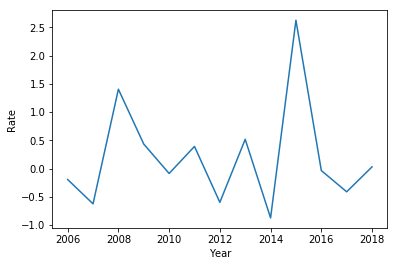

--------------
Denver-Aurora, CO\12


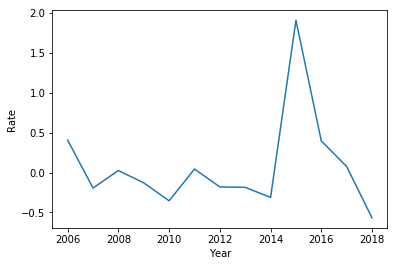

--------------
Detroit-Warren-Livonia, MI\13


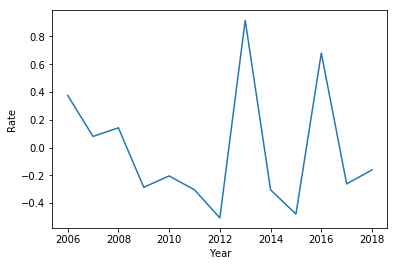

--------------
El Paso, TX


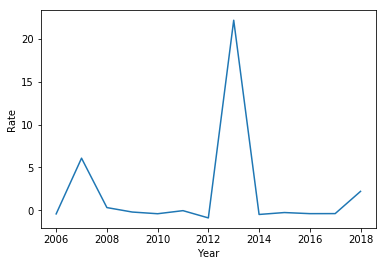

--------------
Fresno, CA


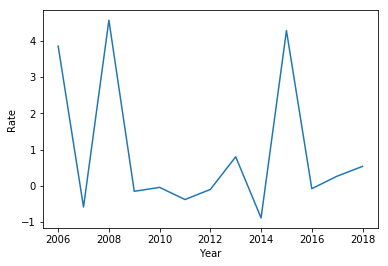

--------------
Grand Rapids-Wyoming, MI\14


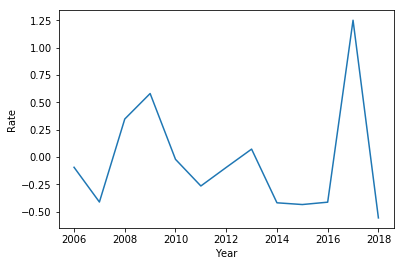

--------------
Greensboro-High Point, NC\15


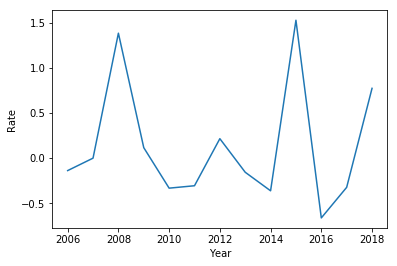

--------------
Hartford-West Hartford-East Hartford, CT\16


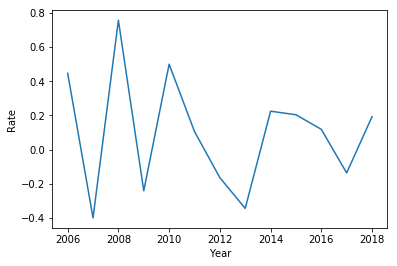

--------------
Honolulu, HI


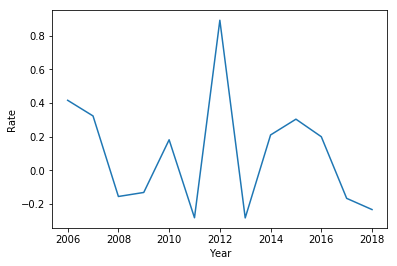

--------------
Houston-Baytown-Sugar Land, TX\17


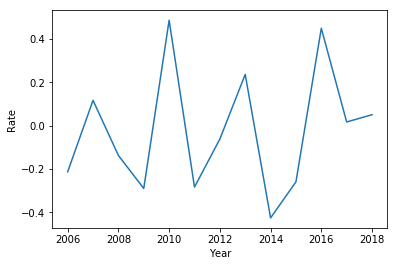

--------------
Indianapolis, IN


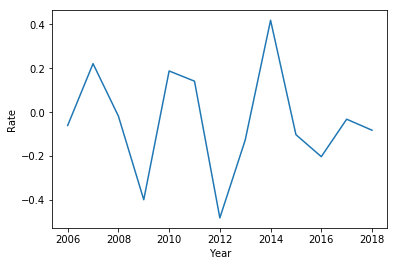

--------------
Jacksonville, FL


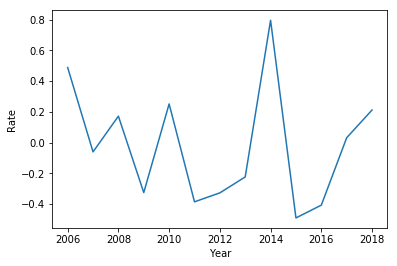

--------------
Kansas City, MO-KS


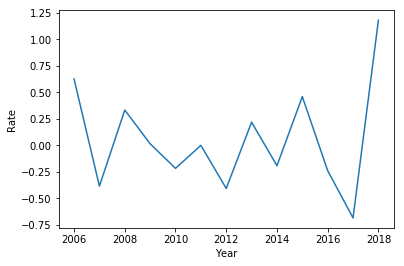

--------------
Las Vegas-Paradise, NV\18


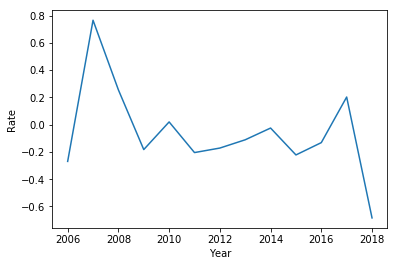

--------------
Los Angeles-Long Beach-Santa Ana, CA \19


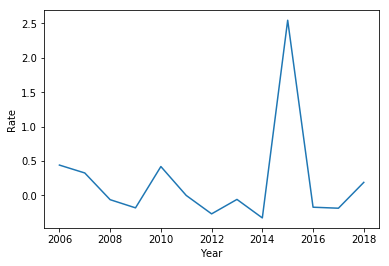

--------------
Louisville, KY-IN


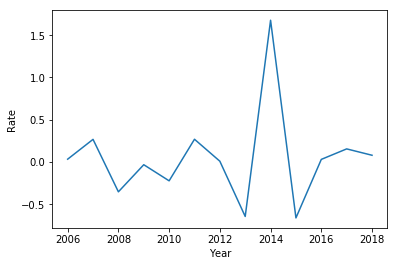

--------------
Memphis, TN-AR-MS


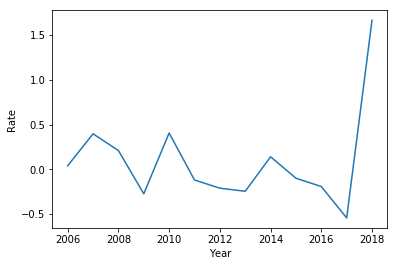

--------------
Miami-Fort Lauderdale-Miami Beach, FL\20


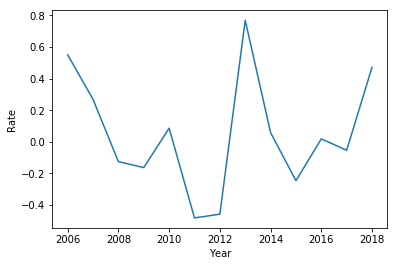

--------------
Milwaukee-Waukesha-West Allis, WI


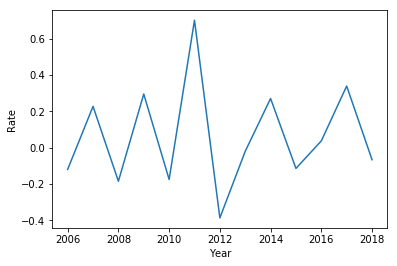

--------------
Minneapolis-St. Paul-Bloomington, MN-WI 


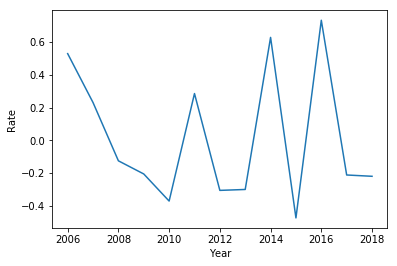

--------------
Nashville-Davidson-Murfreesboro, TN\21


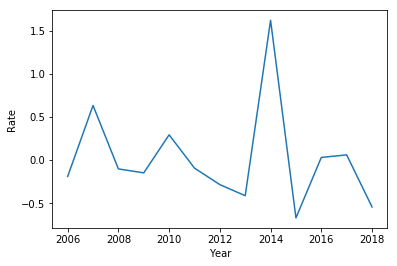

--------------
New Haven-Milford, CT


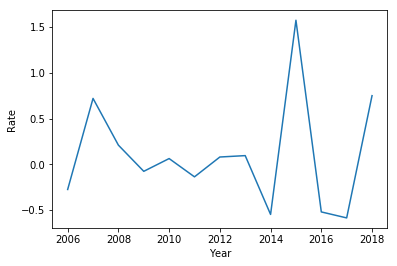

--------------
New Orleans-Metairie-Kenner, LA\22


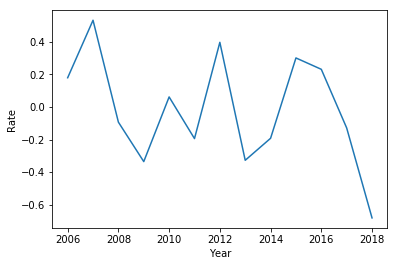

--------------
New York-Northern New Jersey--Long Island, NY\23


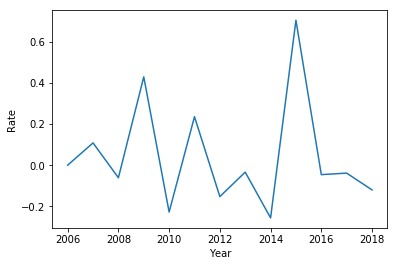

--------------
Oklahoma City, OK


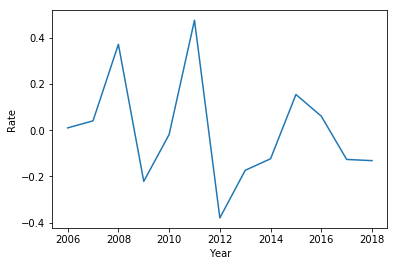

--------------
Omaha-Council Bluffs, NE-IA


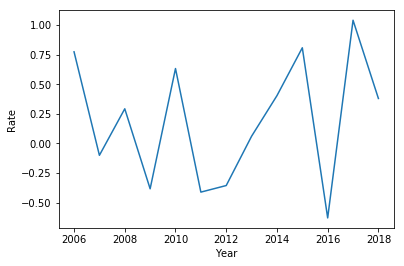

--------------
Orlando, FL


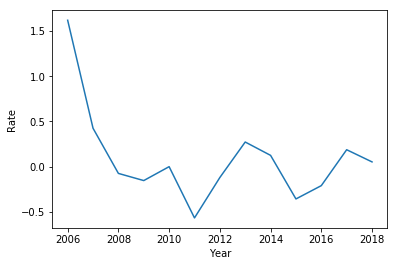

--------------
Oxnard-Thousand Oaks-Ventura, CA


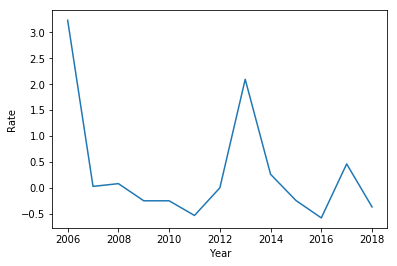

--------------
Philadelphia-Camden-Wilmington, PA


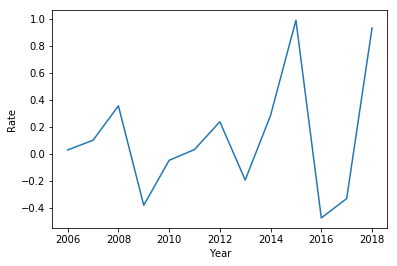

--------------
Phoenix-Mesa-Scottsdale, AZ\24


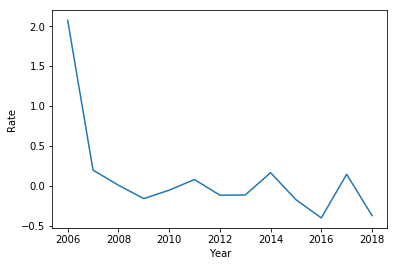

--------------
Pittsburgh, PA


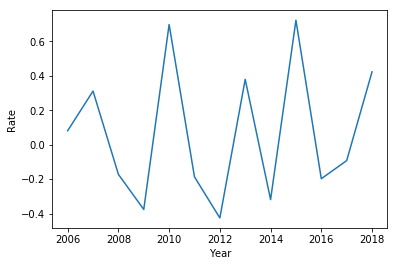

--------------
Portland-Vancouver-Beaverton, OR-WA\25


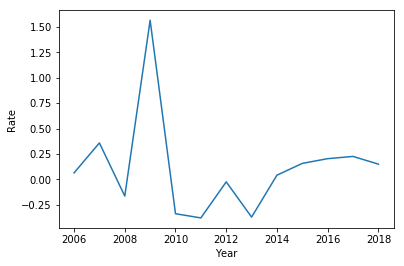

--------------
Poughkeepsie-Newburgh-Middletown, NJ


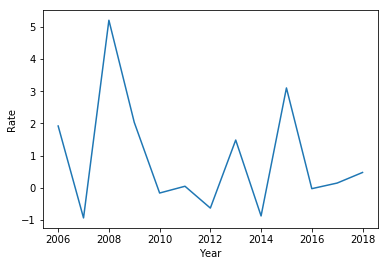

--------------
Providence-New Bedford-Fall River RI-MA\26


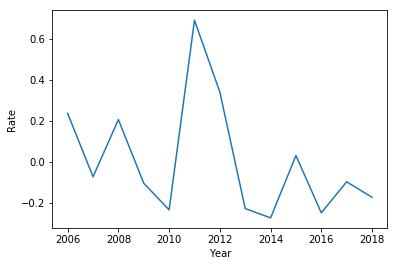

--------------
Raleigh-Cary, NC\27


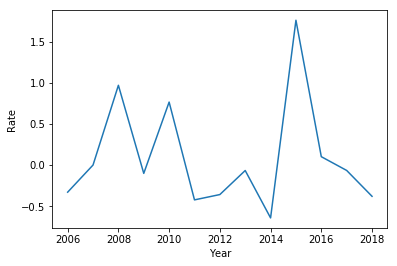

--------------
Richmond, VA\28


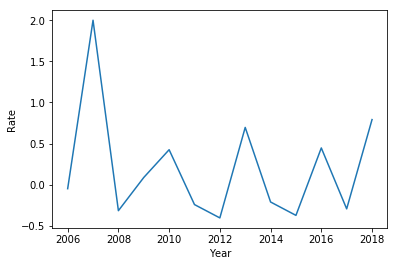

--------------
Riverside-San Bernardino-Ontario, CA\29


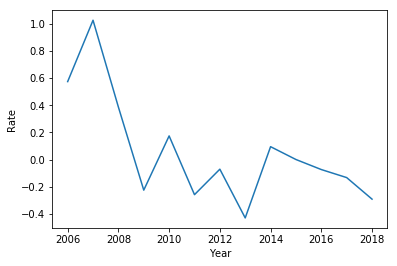

--------------
Rochester, NY


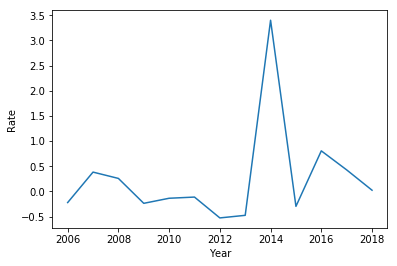

--------------
Sacramento-Arden-Arcade-Roseville, CA\30


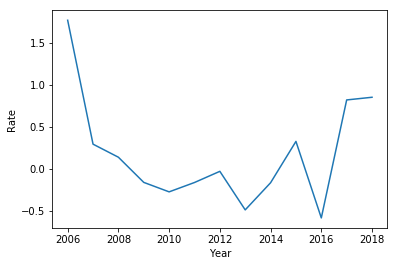

--------------
Salt Lake City, UT\31\


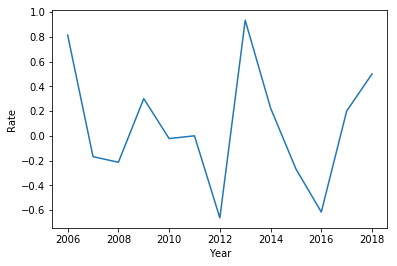

--------------
San Antonio, TX


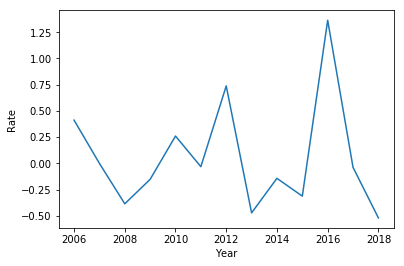

--------------
San Diego-Carlsbad-San Marcos, CA\32


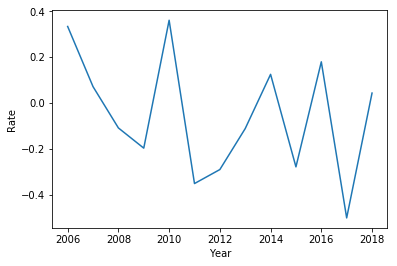

--------------
San Francisco-Oakland-Fremont, CA\33


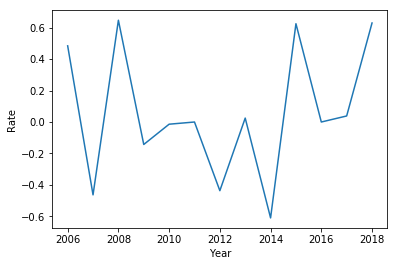

--------------
San Jose-Sunnyvale-Santa Clara, CA\34


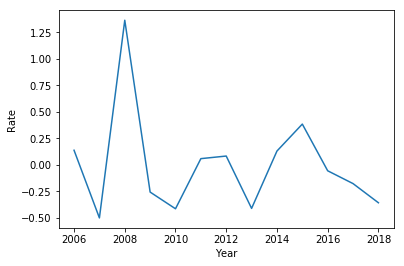

--------------
Seattle-Tacoma-Bellevue, WA


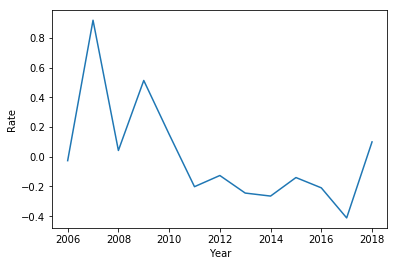

--------------
Springfield, MA


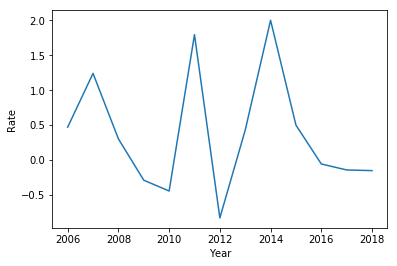

--------------
St. Louis, MO-IL


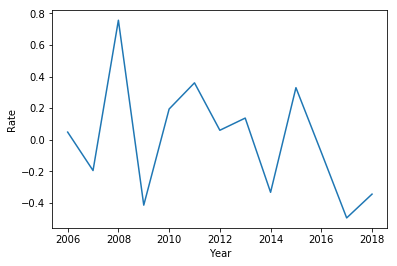

--------------
Syracuse, NY


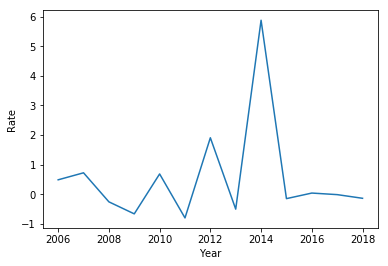

--------------
Tampa-St. Petersburg-Clearwater, FL


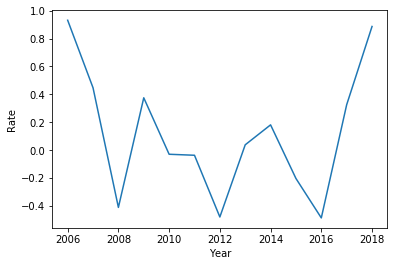

--------------
Toledo, OH


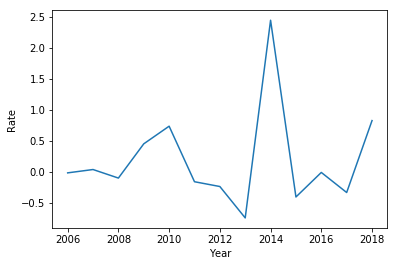

--------------
Tucson, AZ


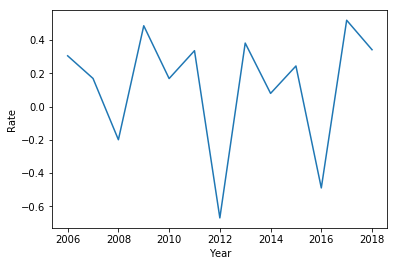

--------------
Tulsa, OK


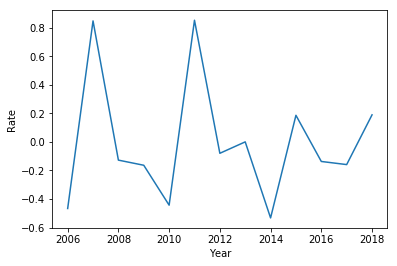

--------------
Virginia Beach-Norfolk-Newport News, VA\35


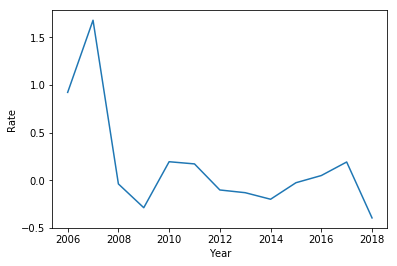

--------------
Washington-Arlington-Alexandria, DC-VA-MD-WV\36


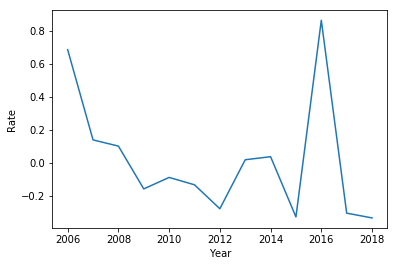

--------------
Worcester, MA


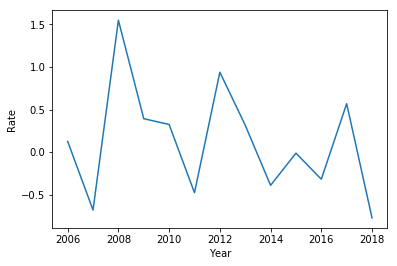

--------------


In [253]:
# Vacancy Rates percentage change YoY for each city from 2006 to 2018
for MSA in vacancy_change.columns.tolist():
    print(MSA)
    MSA_percentage = vacancy_change[MSA]
    ax = MSA_percentage.plot(kind='line')
    ax.set_ylabel("Rate")
    plt.show()
    print('--------------')